# Przewidywanie potencjalnie niebezpiecznych asteroid

### Ten projekt dotyczy obiektów NEO (Near Earth Object), jednak skupia się on wyłącznie na asteroidach. Ma on na celu predykcję, czy dana asteroida jest potencjalnie niebezpieczna dla Ziemi - są to wartości Y/N, zatem możemy użyć tutaj klasyfikacji.
### Najważniejszymi atrybutami są minimalna odległość przecięcia orbity Ziemi (MOID) oraz wielkość absolutna H. Gdy moid jest równe bądź mniejsze od 0.05au oraz H jest równe bądź mniejsze 22.0, asteroida oznaczana jest jako PHA (Potentially Hazardous Asteroid). 

### Dane zostały pozyskane z ogólnodostępnej bazy Jet Propulsion Laboratory, jednej z centrów badawczych NASA w Kalifornii
##### strona JPL: https://www.jpl.nasa.gov/

#### Wykorzystane biblioteki

In [574]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

import os
from time import sleep
import datetime as dt
from textwrap import wrap

import numpy as np
import pandas as pd
pd.options.display.max_columns = None

from seaborn import heatmap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

## Web Scrapping
Do pozyskiwania danych został wykorzystany web scraper bazujący na Selenium. Baza w postaci pliku .csv zostaje pobrana do folderu, w którym znajduje się plik tego notebooka.

In [575]:
url = 'https://ssd.jpl.nasa.gov/tools/sbdb_query.html'

options = Options()
options.add_experimental_option("prefs", {
  "download.default_directory": os.getcwd(),
  "download.prompt_for_download": False,
  "download.directory_upgrade": True,
  "safebrowsing.enabled": True
})
driver = webdriver.Chrome(options=options)
driver.get(url)
sleep(2)
driver.maximize_window()
sleep(0.5)

In [576]:
def find_by_xpath(value):
    return driver.find_element(by=By.XPATH, value=value)

Po przejściu na stronę bazy, wybrane zostają potrzebne w tym projekcie opcje (limitery) - tylko obiekty NEO, które są asteroidami

In [577]:
# limiter object kind/group
find_by_xpath('/html/body/div[3]/div[1]/div[2]/div/div/div/div[2]/div[1]/div[1]/div').click()
sleep(1)

# tylko NEO
find_by_xpath('/html/body/div[3]/div[1]/div[2]/div/div/div/div[2]/div[1]/div[2]/div/form/div[1]/div/table/tbody/tr[1]/td/label[2]').click()
sleep(0.5)

# tylko asteroidy
find_by_xpath('/html/body/div[3]/div[1]/div[2]/div/div/div/div[2]/div[1]/div[2]/div/form/div[1]/div/table/tbody/tr[2]/td/label[2]').click()
sleep(0.5)

# zaznaczenie opcji exclude comet fragments
find_by_xpath('/html/body/div[3]/div[1]/div[2]/div/div/div/div[2]/div[1]/div[2]/div/form/div[1]/div/table/tbody/tr[4]/td/label').click()
sleep(0.5)

Zostają zaaplikowane podstawowe filtry dla asteroid

In [578]:
# kliknij output selection controls
find_by_xpath('/html/body/div[3]/div[1]/div[3]/div/div/div/div[1]/div').click()
sleep(1)
driver.execute_script('window.scrollBy(0, 1000)')
sleep(1)

# kliknij apply asteroid basic filters
find_by_xpath('/html/body/div[3]/div[1]/div[3]/div/div/div/div[2]/div[2]/div/button').click()
sleep(2)

Następnie zaznaczone zostają wszystkie pozostałe filtry, które będą dodane do zapytania

In [579]:
# kliknij select all fields
find_by_xpath('/html/body/div[3]/div[1]/div[3]/div/div/div/div[2]/div[4]/div[1]/div/div/button[1]').click()
sleep(0.5)

# kliknij add all fields
find_by_xpath('/html/body/div[3]/div[1]/div[3]/div/div/div/div[2]/div[4]/div[1]/div/div/span/button').click()
sleep(3)

Wybierana jest pełna precyzja, a wyniki zapytania zostają pobrane. Driver zostaje zamknięty

In [580]:
# zaznacz pełną precyzję
find_by_xpath('/html/body/div[3]/div[1]/div[3]/div/div/div/div[2]/div[4]/div[2]/div/h4/small/label/span/input').click()

# kliknij get the results
find_by_xpath('/html/body/div[3]/div[1]/div[4]/div/div/div/div/button').click()
sleep(5)

# pobierz csv
find_by_xpath('/html/body/div[3]/div[1]/div[4]/div/div/div[1]/div[2]/button').click()
sleep(10)

driver.quit()

Nazwa pliku zostaje zmieniona

In [581]:
!mv ./sbdb_query_results.csv.crdownload sbdb_query.csv

mv: cannot stat './sbdb_query_results.csv.crdownload': No such file or directory


## Eksploracja danych, ich oczyszczanie i  przetwarzanie

Przejrzenie ramki danych, jej kolumn i wartości

In [582]:
asteroids = pd.read_csv('./sbdb_query.csv')
asteroids.head()

/home/s26549/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning:

Columns (17,18,28,35,36,69) have mixed types.Specify dtype option on import or set low_memory=False.



,full_name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,n_del_obs_used,n_dop_obs_used,H,spkid,pdes,name,prefix,neo,pha,G,M1,M2,K1,K2,PC,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,H_sigma,diameter_sigma,orbit_id,epoch,epoch_mjd,epoch_cal,equinox,ma,n,tp,tp_cal,per,moid,moid_ld,moid_jup,t_jup,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,producer,first_obs,last_obs,rms,two_body,A1,A2,A3,DT
0,433 Eros (A898 PA),1.458151,0.222733,10.827958,304.291056,178.932515,1.133373,1.782929,1.760807,46582.0,0.0,9130,4.0,2.0,10.31,2000433,433,Eros,NaN,Y,N,0.46,NaN,NaN,NaN,NaN,NaN,16.840,34.4x11.2x11.2,0.250,5.270,0.000446,0.921,0.531,NaN,S,S,NaN,0.060,659,2459800.5,59800,2022-08-09.0000000,J2000,358.821259,0.559758,2.459803e+06,2022-08-11.1058043,643.134746,0.150418,58.538173,3.28665,4.582,9.382800e-09,1.566400e-10,1.368900e-08,1.158000e-06,0.000004,0.000004,0.000001,1.915300e-10,9.019800e-11,0.000003,1.036300e-07,AMO,Giorgini,1893-10-29,2021-05-13,0.29796,NaN,NaN,NaN,NaN,NaN
1,719 Albert (A911 TB),2.636929,0.546982,11.575963,183.857334,156.246075,1.194577,4.079281,4.282090,40423.0,0.0,2005,NaN,NaN,15.57,2000719,719,Albert,NaN,Y,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.801,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,JPL 249,2459800.5,59800,2022-08-09.0000000,J2000,324.203180,0.230174,2.459956e+06,2023-01-11.5206098,1564.033331,0.201259,78.323965,1.41881,3.141,2.145400e-08,2.519000e-09,5.719800e-08,2.824200e-06,0.000015,0.000015,0.000003,3.896900e-09,3.298200e-10,0.000012,2.241200e-06,AMO,Otto Matic,1911-10-04,2022-06-06,0.40987,NaN,NaN,NaN,NaN,NaN
2,887 Alinda (A918 AA),2.472767,0.570579,9.395004,110.425532,350.480803,1.061858,3.883677,3.888509,37799.0,0.0,2652,NaN,NaN,13.84,2000887,887,Alinda,NaN,Y,N,-0.12,NaN,NaN,NaN,NaN,NaN,4.200,NaN,0.310,28.410,NaN,0.832,0.436,NaN,NaN,S,NaN,NaN,430,2459800.5,59800,2022-08-09.0000000,J2000,137.322315,0.253472,2.459259e+06,2021-02-13.2338122,1420.277745,0.082439,32.082941,1.31844,3.221,2.689200e-08,2.962500e-09,6.687700e-08,3.125500e-06,0.000023,0.000024,0.000004,4.652900e-09,4.555100e-10,0.000014,2.552400e-06,AMO,Otto Matic,1918-02-03,2021-07-31,0.40185,NaN,NaN,NaN,NaN,NaN
3,1036 Ganymed (A924 UB),2.665942,0.533102,26.681986,215.505000,132.451320,1.244722,4.087161,4.352955,35629.0,0.0,7543,0.0,1.0,9.23,2001036,1036,Ganymed,NaN,Y,N,0.30,NaN,NaN,NaN,NaN,NaN,37.675,NaN,0.238,10.297,NaN,0.842,0.417,NaN,S,S,NaN,0.399,999,2459800.5,59800,2022-08-09.0000000,J2000,185.907851,0.226427,2.460569e+06,2024-09-15.8667018,1589.916691,0.344996,134.262093,1.95186,3.034,1.111300e-08,1.870400e-09,2.992000e-08,4.917700e-07,0.000001,0.000001,0.000002,2.867600e-09,2.382900e-10,0.000007,1.673200e-06,AMO,Otto Matic,1924-10-23,2022-05-11,0.36642,NaN,NaN,NaN,NaN,NaN
4,1221 Amor (1932 EA1),1.918933,0.435879,11.883288,171.319333,26.633761,1.082509,2.755356,2.658262,32775.0,0.0,585,NaN,NaN,17.38,2001221,1221,Amor,NaN,Y,N,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111,2459800.5,59800,2022-08-09.0000000,J2000,335.221916,0.370778,2.459867e+06,2022-10-14.8271996,970.930262,0.107172,41.708127,2.20959,3.781,3.330500e-08,9.539700e-10,6.430200e-08,4.455800e-06,0.000021,0.000023,0.000008,1.369800e-09,2.764900e-10,0.000021,7.240300e-07,AMO,Otto Matic,1932-03-12,2021-12-05,0.44014,NaN,NaN,NaN,NaN,NaN


In [583]:
asteroids.columns

Index(['full_name', 'a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc',
       'condition_code', 'n_obs_used', 'n_del_obs_used', 'n_dop_obs_used', 'H',
       'spkid', 'pdes', 'name', 'prefix', 'neo', 'pha', 'G', 'M1', 'M2', 'K1',
       'K2', 'PC', 'diameter', 'extent', 'albedo', 'rot_per', 'GM', 'BV', 'UB',
       'IR', 'spec_B', 'spec_T', 'H_sigma', 'diameter_sigma', 'orbit_id',
       'epoch', 'epoch_mjd', 'epoch_cal', 'equinox', 'ma', 'n', 'tp', 'tp_cal',
       'per', 'moid', 'moid_ld', 'moid_jup', 't_jup', 'sigma_e', 'sigma_a',
       'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma', 'sigma_ad',
       'sigma_n', 'sigma_tp', 'sigma_per', 'class', 'producer', 'first_obs',
       'last_obs', 'rms', 'two_body', 'A1', 'A2', 'A3', 'DT'],
      dtype='object')

### Co przedstawiają poszczególne kolumny?
#### Na podstawie opisów ze strony centrum JPL, tłumaczenie może nie być w 100% dokładne
full_name - pełna nazwa obiektu<br>
a - półoś wielka (au)<br>
e - ekscentryczność (mimośród) orbity<br>
i - inklinacja, kąt w stosunku do płaszczyzny ekliptyki x-y (deg)<br>
om - node; długość geograficzna węzła wstępującego (deg)<br>
w - argument peryhelium (deg)<br>
q - odległość peryhelium (au)<br>
ad - Q; odległość aphelium (au)<br>
per_y - okres orbitalny (years)<br>
data_arc - rozpiętość łuku danych; liczba dni przez które przebiega łuk danych<br>
condition_code - kod stanu orbity (parametr MPC 'U')<br>
n_obs_used - liczba obserwacji (wszystkich typów) wykorzystanych w dopasowaniu<br>
n_del_obs_used - liczba obserwacji radarowych z opóźnieniem wykorzystanych w dopasowaniu<br>
n_dop_obs_used - liczba obserwacji radarowych Dopplera wykorzystanych w dopasowaniu<br>
H - parametr magnitudy absolutnej<br>
spkid - pierwotny SPK-ID obiektu<br>
pdes - oznaczenie pierwotne obiektu<br>
name - nazwa obiektu IAU<br>
prefix - prefiks oznaczenia komety<br>
neo - flaga obiektu bliskiego Ziemi<br>
pha - flaga potencjalnie niebezpiecznej asteroidy<br>
G - parametr nachylenia magnitudy<br>
M1 - parametr całkowitej magnitudy komety<br>
M2 - parametr magnitudy jądrowej komety<br>
K1 - parametr nachylenia magnitudy całkowitej komety<br>
K2 - parametr nachylenia magnitudy jądrowej komety<br>
PC - prawo magnitudy jądrowej komety - współczynnik fazowy<br>
diameter - średnica obiektu (od równoważnej kuli) (km)<br>
extent - rozciągłość - wymiary dwu-/trójosiowej elipsoidy obiektu (km)<br>
albedo - albedo geometryczne; zdolnośc odbijania promieni<br>
rot_per - okres rotacji (h)<br>
GM - standardowy parametr grawitacyjny (km^3/s^2)<br>
BV - indeks koloru B-V<br>
UB - indeks koloru U-B<br> 
IR - indeks koloru I-R<br>
spec_B - spektralny typ taksonomiczny (SMASSII)<br>
spec_T - spektralny typ aksonomiczny (Tholen)<br>
H_sigma - niepewność 1-sigma wielkości absolutnej H<br>
diameter_sigma - niepewność 1-sigma średnicy obiektu<br>
orbit_id - id orbity<br>
epoch - epoka oscylacji w formie dnia juliańskiego (TDB)<br>
epoch_mjd - epoka oscylacji w zmodyfikowanej formie dnia juliańskiego (TDB)<br>
epoch_cal - epoka oscylacji w postaci data/czas kalendarzowego (TDB)<br>
equinox - równonoc w ramce odniesienia<br>
ma - średnia anomalia (deg)<br>
n - ruch średni (deg/d)<br>
tp - czas przejścia przez peryhelium (TDB)<br>
tp_cal - czas przejścia przez peryhelium (TDB)<br>
per - okres orbitalny (d)<br>
moid - minimalna odległość przecięcia orbity Ziemi (au)<br>
moid_ld - minimalna odległość przecięcia orbity Ziemi (LD)<br>
moid_jup - minimalna odległość przecięcia orbity Jowisza (au)<br>
t_jup - niezmiennik Tisseranda Jowisza<br>
sigma_e - ekscentryczność (niepewność 1-sigma)<br>
sigma_a - półoś wielka (niepewność 1-sigma) (au)<br>
sigma_q - odległość peryhelium (niepewność 1-sigma) (au)<br>
sigma_i - inklinacja (niepewność 1-sigma) (deg)<br>
sigma_om - długość węzła wstępującego (niepewność 1-sigma) (deg)<br>
sigma_w - argument peryhelionu (niepewnośc 1-sigma) (deg)<br>
sigma_ma - średnia anomalia (niepewność 1-sigma) (deg)<br>
sigma_ad - odległość aphelium (niepewność 1-sigma) (au)<br>
sigma_n - średni ruch (niepewność 1-sigma) (deg/d)<br>
sigma_tp - czas przejścia okołoziemskiego (niepewnosć 1-sigma) (d)<br>
sigma_per - okres orbitalny w ruchu bocznym (niepewność 1-sigma) (d)<br> 
class - klasa orbity<br>
producer - nazwisko osoby lub instytucja, która obliczyła orbitę<br>
first_obs - data pierwszej obserwacji wykorzystanej w dopasowaniu orbity (UT)<br>
last_obs - data ostatniej obserwacji wykorzystanej w dopasowaniu orbity (UT)<br>
rms - znormalizowane RMS dopasowania orbity (arcsec)<br>
two_body - flaga użycia dynamiki 2 ciał<br>
A1 - parametr radialny niegrawitacyjny<br>
A2 - parametr poprzeczny niegrawitacyjny<br>
A3 - parametr normalny niegrawitacyjny<br>
DT - niegrawitacyjne przesunięcie okołomaksymalne (d)

Widać, że niektóre atrybuty dotyczą tylko komet. Nie powinny one zatem mieć wstawionych wartości w przypadku gdy zapytaliśmy tylko o asteroidy

In [584]:
asteroids.describe()

,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,n_del_obs_used,n_dop_obs_used,H,spkid,G,M1,M2,K1,K2,PC,diameter,albedo,rot_per,GM,BV,UB,IR,H_sigma,diameter_sigma,epoch,epoch_mjd,ma,n,tp,per,moid,moid_ld,moid_jup,t_jup,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms,A1,A2,A3,DT
count,29153.000000,29153.000000,29153.000000,29153.000000,29153.000000,29153.000000,29153.000000,29153.000000,28910.000000,29151.000000,29153.000000,970.000000,970.000000,29148.000000,2.915300e+04,13.000000,0.0,0.0,0.0,0.0,0.0,1248.000000,1203.000000,1881.000000,5.000000e+00,38.000000,38.000000,1.00,11044.000000,1160.000000,2.915300e+04,29153.000000,29153.000000,29153.000000,2.915300e+04,2.915300e+04,2.912300e+04,29123.000000,29123.000000,29153.000000,2.912300e+04,2.912300e+04,2.912300e+04,2.912300e+04,2.912300e+04,2.912300e+04,2.912300e+04,2.912300e+04,2.912300e+04,2.912300e+04,2.912300e+04,29153.000000,1.200000e+01,2.580000e+02,2.000000e+00,0.0
mean,1.767983,0.439503,12.231770,172.249926,182.450092,0.913997,2.621968,2.655750,1377.747181,5.109739,107.252976,2.361856,1.698969,23.241878,1.556046e+07,0.114538,NaN,NaN,NaN,NaN,NaN,1.032242,0.172529,18.207007,8.927385e-05,0.814263,0.416500,-0.33,0.376255,0.143142,2.459122e+06,59121.030220,171.771229,0.524258,2.459111e+06,9.700127e+02,8.894248e-02,34.613744,2.701792,4.271009,4.571525e-03,2.989303e-02,2.173997e-03,9.927416e-02,2.387347e-01,4.747582e-01,1.454769e+00,5.098367e-02,4.829187e-03,3.056822e+00,5.433731e+01,0.479873,6.823931e-11,-2.595602e-13,-1.663832e-11,NaN
std,2.051578,0.177029,10.885828,103.582900,104.338519,0.228326,4.084183,33.759742,3040.440559,3.217746,261.683091,3.710358,2.357628,2.935886,2.160663e+07,0.238644,NaN,NaN,NaN,NaN,NaN,1.651000,0.144030,75.018817,1.995837e-04,0.091066,0.102057,NaN,0.119711,0.264177,1.518184e+03,1518.184208,120.847363,0.282734,1.536298e+03,1.233075e+04,1.000360e-01,38.931020,0.965757,1.073236,1.148203e-01,1.224375e+00,4.748245e-02,3.083973e+00,1.567791e+01,1.431158e+01,1.283282e+02,2.286022e+00,1.281511e-01,2.977188e+02,4.289766e+03,0.126135,5.137324e-11,3.188249e-12,2.331315e-11,NaN
min,0.461705,0.002846,0.006034,0.013994,0.006755,0.070431,0.653766,0.313729,1.000000,0.000000,4.000000,0.000000,0.000000,9.230000,2.000433e+06,-0.250000,NaN,NaN,NaN,NaN,NaN,0.002500,0.009000,0.003298,2.100000e-09,0.640000,0.160000,-0.33,0.000000,0.000000,2.444222e+06,44221.000000,0.004689,0.000174,2.444268e+06,1.145896e+02,8.722540e-08,0.000034,0.000239,-1.205000,6.974800e-11,4.688300e-11,2.304700e-10,6.860100e-09,5.557700e-08,6.441900e-08,4.274900e-08,5.432100e-11,5.710800e-11,2.253600e-08,2.634500e-08,0.043245,-3.064373e-13,-5.065687e-11,-3.312320e-11,NaN
25%,1.299073,0.307772,4.495007,81.440078,92.828629,0.787311,1.681137,1.480671,7.000000,1.000000,27.000000,0.000000,1.000000,21.000000,3.514890e+06,-0.031000,NaN,NaN,NaN,NaN,NaN,0.309750,0.047500,2.245500,4.890400e-09,0.763750,0.368500,-0.33,0.298432,0.016000,2.459386e+06,59386.000000,53.204411,0.306658,2.459202e+06,5.408151e+02,1.411535e-02,5.493271,1.959325,3.436000,6.469800e-07,1.583500e-07,6.049100e-07,4.073200e-05,5.640200e-05,1.216450e-04,2.564500e-04,2.311800e-07,6.581100e-08,3.511500e-04,1.174500e-04,0.394460,4.265118e-11,-1.195758e-13,-2.488076e-11,NaN
50%,1.698248,0.453315,8.609980,171.434250,184.615802,0.962828,2.449074,2.213145,27.000000,6.000000,46.000000,1.000000,1.000000,23.500000,3.756792e+06,0.100000,NaN,NaN,NaN,NaN,NaN,0.629000,0.137000,4.787000,3.000000e-08,0.830000,0.454500,-0.33,0.364610,0.052000,2.459800e+06,59800.000000,164.548143,0.445351,2.459659e+06,8.083512e+02,4.858560e-02,18.908058,2.845780,4.031000,1.632100e-04,3.226800e-04,2.599700e-05,2.032300e-03,5.586300e-04,1.920900e-03,6.137800e-02,4.440800e-04,1.710000e-04,3.054700e-02,2.207000e-01,0.470170,6.027015e-11,-4.426745e-14,-1.663832e-11,NaN
75%,2.177875,0.566264,17.182662,253.051395,272.558114,1.063656,3.365411,3.214087,1269.000000,8.000000,91.000000,3.000000,2.000000,25.400000,3.989096e+06,0.24

Na pierwszy rzut oka widać, że występują tu kolumny bez żadnych wartości

In [585]:
asteroids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29153 entries, 0 to 29152
Data columns (total 74 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   full_name       29153 non-null  object 
 1   a               29153 non-null  float64
 2   e               29153 non-null  float64
 3   i               29153 non-null  float64
 4   om              29153 non-null  float64
 5   w               29153 non-null  float64
 6   q               29153 non-null  float64
 7   ad              29153 non-null  float64
 8   per_y           29153 non-null  float64
 9   data_arc        28910 non-null  float64
 10  condition_code  29151 non-null  float64
 11  n_obs_used      29153 non-null  int64  
 12  n_del_obs_used  970 non-null    float64
 13  n_dop_obs_used  970 non-null    float64
 14  H               29148 non-null  float64
 15  spkid           29153 non-null  int64  
 16  pdes            29153 non-null  object 
 17  name            166 non-null   

Potwierdza się to przy sprawdzaniu informacji o ramce. Dodatkowo, występują kolumny z małą ilością wartości.
Sprawdźmy kolumny identyfikacyjne

In [586]:
print(asteroids['spkid'].nunique())
print(asteroids['full_name'].nunique())
print(asteroids['pdes'].nunique())

29153
29153
29153


In [587]:
asteroids[['spkid', 'full_name', 'pdes']]

,spkid,full_name,pdes
0,2000433,433 Eros (A898 PA),433
1,2000719,719 Albert (A911 TB),719
2,2000887,887 Alinda (A918 AA),887
3,2001036,1036 Ganymed (A924 UB),1036
4,2001221,1221 Amor (1932 EA1),1221
...,...,...,...
29148,54287659,(2022 MN),2022 MN
29149,54288263,(2022 MO),2022 MO
29150,54288264,(2022 MP),2022 MP
29151,54288265,(2022 MQ),2022 MQ


Jak widać, wszystkie wartości są unikalne i nie zawsze wartości te są od siebie zależne. Można zatem pozbyć się dwóch z nich

In [588]:
asteroids.drop(['spkid', 'pdes'], axis=1, inplace=True)

Sprawdźmy, czy występują jakieś obserwacje bez flagi PHA, która będzie przewidywana

In [589]:
print(asteroids['pha'].notna().count())
no_pha = np.where(pd.isnull(asteroids['pha']))
print(len(no_pha[0]), no_pha)
asteroids.loc[no_pha]

29153
30 (array([ 3229,  7814, 10118, 11039, 11040, 11041, 11043, 11044, 11045,
       11048, 11172, 11173, 11174, 11175, 11176, 11682, 11954, 11955,
       11956, 13229, 13712, 14167, 14169, 14170, 14288, 14289, 14541,
       14892, 16899, 20766]),)


,full_name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,n_del_obs_used,n_dop_obs_used,H,name,prefix,neo,pha,G,M1,M2,K1,K2,PC,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,H_sigma,diameter_sigma,orbit_id,epoch,epoch_mjd,epoch_cal,equinox,ma,n,tp,tp_cal,per,moid,moid_ld,moid_jup,t_jup,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,producer,first_obs,last_obs,rms,two_body,A1,A2,A3,DT
3229,(1998 HP126),0.794025,0.472291,0.73891,183.60195,241.11499,0.419014,1.169035,0.707553,1.0,9.0,15,NaN,NaN,25.77,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E2021-PC0,2459400.5,59400,2021-07-05.0000000,J2000,46.10236,1.393007,2.459367e+06,2021-06-01.9044226,258.433795,NaN,NaN,NaN,7.242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ATE,Pan,1998-04-24,1998-04-25,0.59,F,NaN,NaN,NaN,NaN
7814,(2010 VG145),2.135174,0.526285,2.86897,181.27656,158.53931,1.011464,3.258883,3.120024,7.0,9.0,9,NaN,NaN,22.92,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E2021-PC0,2459400.5,59400,2021-07-05.0000000,J2000,169.92762,0.315903,2.458863e+06,2020-01-14.0899641,1139.588802,NaN,NaN,NaN,3.525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APO,Pan,2010-11-06,2010-11-13,0.59,F,NaN,NaN,NaN,NaN
10118,(2013 NE24),2.789697,0.661376,0.40667,320.57941,289.33562,0.944657,4.634736,4.659547,1.0,NaN,6,NaN,NaN,27.30,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E2021-CI3,2456480.5,56480,2013-07-07.0000000,J2000,5.58100,0.211528,2.456454e+06,2013-06-10.6158297,1701.899533,NaN,NaN,NaN,2.964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APO,Veres,2013-07-14,2013-07-15,0.05,T,NaN,NaN,NaN,NaN
11039,(2014 HY191),2.008991,0.465929,3.64131,53.91734,118.43046,1.072944,2.945038,2.847575,3.0,9.0,10,NaN,NaN,25.19,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E2021-PC0,2459400.5,59400,2021-07-05.0000000,J2000,203.91027,0.346128,2.459851e+06,2022-09-28.9591284,1040.076667,NaN,NaN,NaN,3.687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AMO,Pan,2014-04-23,2014-04-26,0.48,F,NaN,NaN,NaN,NaN
11040,(2014 HA192),1.340000,0.724791,7.91701,41.17206,43.87986,0.368780,2.311221,1.551192,2.0,9.0,13,NaN,NaN,25.54,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E2021-PC0,2459400.5,59400,2021-07-05.0000000,J2000,268.29699,0.635399,2.459545e+06,2021-11-26.3234220,566.572809,NaN,NaN,NaN,4.576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APO,Pan,2014-04-23,2014-04-25,0.94,F,NaN,NaN,NaN,NaN
11041,(2014 HB192),2.150955,0.705027,3.60375,47.80498,259.93101,0.634474,3.667436,3.154680,2.0,9.0,13,NaN,NaN,26.20,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E2021-PC0,2459400.5,59400,2021-07-05.0000000,J2000,83.30212,0.312433,2.459134e+06,2020-10-11.3760945,1152.246857,NaN,NaN,NaN,3.329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APO,Pan,2014-04-23,2014-04-25,0.44,F,NaN,NaN,NaN,NaN
11043,(2014 HD192),2.096429,0.540230,5.79025,35.78428,132.63378,0.963875,3.228983,3.035487,2.0,9.0,12,NaN,NaN,27.72,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E2021-PC0,2459400.5,59400,2021-07-05.0000000,J2000,146.45044,0.324701,2.458949e+06,2020-04-09.9685485,1108.711743,NaN,NaN,NaN,3.545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APO,Pan,2014-04-24,2014-04-26,0.83,F,NaN,NaN,NaN,NaN
11044,(2014 HE192),1.759867,0.418471,9.09085,214.01185,33.35077,1.023414,2.496319,2.334683,3.0,8.0,14,NaN,NaN,25.89,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E2021-PC0,2459400.5,59400,2021-07-05.0000000,J2000,16.83130,0.422167,2.459361e+06,2021-05-26.1311945,852.742806,NaN,NaN,NaN,4.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AMO,Pan,2014-04-23,2014-04-26,0.79,F,NaN,NaN,NaN,NaN
11045,(2014 HF192),2.322031,0.509162,17.11842,35.46111,199.41385,1.139740,3.504321,3.538426,2.0,9.0,1

Jest to tylko 30 obserwacji z ponad 29 tysięcy, więc z czystym sumieniem mogą one zostać usunięte

In [590]:
asteroids.drop(no_pha[0], inplace=True)
asteroids.shape[0]

29123

Sprawdźmy rozkład wartości przewidywanej PHA

In [591]:
pha_dist = asteroids['pha'].value_counts(normalize=True)*100
pha_dist = pha_dist.round(2)
# pha_dist

fig = px.pie(pha_dist, values=pha_dist, names=pha_dist.index, title='% PHA distribution')
fig.update_layout(width=400, height=300)
fig.show()

W danych występuje spora dysproporcja pomiędzy asteroidami, które potencjalnie nam nie zagrażają, a potencjalnie niebezpiecznymi. Chyba dobrze dla nas. Jednak dla tworzenia modeli i ich trenowania wypadałoby pokusić się o nadpróbkowanie klasy z mniejszą ilością obserwacji

Sprawdźmy, czy wszystkie obserwacje na pewno są obiektami NEO. W takim wypadku, jeżeli kolumna ma tylko jedną wartość we wszystkich obserwacjach, to można ją usunąć.

In [592]:
print(asteroids['neo'].value_counts())
# print(asteroids['neo'].value_counts(normalize=True)*100)
asteroids.drop('neo', axis=1, inplace=True)

Y    29123
Name: neo, dtype: int64


Wcześniej zaciekawił mnie atrybut *name*, przyjrzyjmy mu się

In [593]:
asteroids['name'].value_counts()

Eros                 1
Oze                  1
Gordonmoore          1
Akka                 1
Kadlu                1
                    ..
Epona                1
Nyx                  1
Huma                 1
Wilson-Harrington    1
Cecily               1
Name: name, Length: 166, dtype: int64

Wygląda na to, że wszystkie nazwy asteroid są unikalne, nie pomoże więc to w trenowaniu modelu

Wyrzućmy wszystkie kolumny dotyczące komet oraz z bardzo małą liczbą wstawionych wartości. Jako, że nie jestem ekspertem w tej dziedzinie, nie podejmuję się ich uzupełniania, ponieważ mogłoby to niekorzystnie wpłynąć na predykcję 

In [594]:
cols_to_drop = [
    'prefix', 'G', 'M1', 'M2', 'K1', 'K2', 'PC', 'extent', 'UB', 'BV',
    'GM', 'IR', 'two_body', 'A1', 'A2', 'A3', 'DT', 'spec_B', 'spec_T', 'name'
]

asteroids.drop(cols_to_drop, axis=1, inplace=True)

In [595]:
asteroids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29123 entries, 0 to 29152
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   full_name       29123 non-null  object 
 1   a               29123 non-null  float64
 2   e               29123 non-null  float64
 3   i               29123 non-null  float64
 4   om              29123 non-null  float64
 5   w               29123 non-null  float64
 6   q               29123 non-null  float64
 7   ad              29123 non-null  float64
 8   per_y           29123 non-null  float64
 9   data_arc        28881 non-null  float64
 10  condition_code  29123 non-null  float64
 11  n_obs_used      29123 non-null  int64  
 12  n_del_obs_used  970 non-null    float64
 13  n_dop_obs_used  970 non-null    float64
 14  H               29118 non-null  float64
 15  pha             29123 non-null  object 
 16  diameter        1248 non-null   float64
 17  albedo          1203 non-null  

Przyjrzyjmy się atrybutowi *orbit_id*

In [596]:
orbit_id = asteroids['orbit_id'].value_counts()
orbit_id

JPL 2     1178
JPL 3     1074
JPL 4     1026
5         1024
7         1007
          ... 
JPL 76       1
299          1
294          1
409          1
JPL 51       1
Name: orbit_id, Length: 524, dtype: int64

Widać, że niektóre orbity powtarzają się często, natomiast inne występują jedynie kilka razy. Do modelowania zostawmy jedynie te występujące więcej niż 10 razy, a pozostałe oznaczmy jako *Other*

In [597]:
orbits_id_low_occ = asteroids['orbit_id'].value_counts().loc[lambda x: x<10].index
orbits_id_low_occ

Index(['139', '151', '130', '110', '175', '135', '109', '100', '125', '147',
       ...
       '486', 'JPL 387', '338', 'JPL 226', 'JPL 132', 'JPL 76', '299', '294',
       '409', 'JPL 51'],
      dtype='object', length=396)

In [598]:
asteroids.loc[asteroids['orbit_id'].isin(orbits_id_low_occ), 'orbit_id'] = 'Other'
asteroids['orbit_id']

0        Other
1        Other
2        Other
3        Other
4          111
         ...  
29148    JPL 1
29149    JPL 1
29150    JPL 1
29151    JPL 1
29152       19
Name: orbit_id, Length: 29123, dtype: object

Jako, że jest to zmienna kategoryczna, można ją w ten sposób oznaczyć

In [599]:
asteroids['orbit_id'] = asteroids['orbit_id'].astype('category')

In [600]:
asteroids.reset_index(drop=True, inplace=True)
asteroids.shape[0]

29123

In [601]:
asteroids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29123 entries, 0 to 29122
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   full_name       29123 non-null  object  
 1   a               29123 non-null  float64 
 2   e               29123 non-null  float64 
 3   i               29123 non-null  float64 
 4   om              29123 non-null  float64 
 5   w               29123 non-null  float64 
 6   q               29123 non-null  float64 
 7   ad              29123 non-null  float64 
 8   per_y           29123 non-null  float64 
 9   data_arc        28881 non-null  float64 
 10  condition_code  29123 non-null  float64 
 11  n_obs_used      29123 non-null  int64   
 12  n_del_obs_used  970 non-null    float64 
 13  n_dop_obs_used  970 non-null    float64 
 14  H               29118 non-null  float64 
 15  pha             29123 non-null  object  
 16  diameter        1248 non-null   float64 
 17  albedo      

*data_arc* to liczba dni pomiędzy datą pierwszej i ostatniej obserwacji. Może być to ważny atrybut, ponieważ jeżeli asteroida była dłużej obserwowana, jej wartości w innych kolumnach teoretycznie mogą być lepiej wyliczone

In [602]:
asteroids['data_arc'].value_counts()

2.0        1452
1.0        1302
3.0        1132
4.0        1112
5.0         961
           ... 
6128.0        1
7142.0        1
5257.0        1
5906.0        1
22229.0       1
Name: data_arc, Length: 5433, dtype: int64

In [603]:
asteroids['per_y'].value_counts()

1.760807    1
4.325992    1
4.067330    1
1.789961    1
0.951520    1
           ..
2.734588    1
1.561645    1
1.277686    1
4.039422    1
4.737338    1
Name: per_y, Length: 29123, dtype: int64

Jako, że magnituda (wielkość absolutna) *H*, to jeden z kluczowych atrybutów do predykcji PHA, sprawdźmy, czy wszystkie obserwacje zawierają uzupełnioną tę wartość. Teoretycznie, jest ona do wyliczenia na podstawie *albedo* oraz *diameter*, jednak te kolumny posiadają niewiele uzupełnionych wartości. Jeżeli obserwacji bez wartości *H* będzie niewiele, to po prostu ją usuńmy

In [604]:
print(asteroids.loc[asteroids['H'].isna()].shape[0])
no_h = asteroids.loc[asteroids['H'].isna()].index
asteroids.drop(no_h, inplace=True)
asteroids.shape[0]

5


29118

Zajmijmy się datą pierwszej i ostatniej obserwacji

In [605]:
asteroids['first_obs']

0        1893-10-29
1        1911-10-04
2        1918-02-03
3        1924-10-23
4        1932-03-12
            ...    
29118    2022-06-01
29119    2022-06-20
29120    2022-06-21
29121    2022-06-21
29122    1960-09-24
Name: first_obs, Length: 29118, dtype: object

Widać, że kolumna ta jest typu *object*, a wartości są datami. Zmieńmy więc typ kolumny na daty

In [606]:
asteroids['first_obs'] = pd.to_datetime(asteroids['first_obs'])

In [607]:
asteroids['last_obs'] = pd.to_datetime(asteroids['last_obs'])
asteroids['last_obs']

0       2021-05-13
1       2022-06-06
2       2021-07-31
3       2022-05-11
4       2021-12-05
           ...    
29118   2022-06-21
29119   2022-06-22
29120   2022-06-22
29121   2022-06-22
29122   2021-08-04
Name: last_obs, Length: 29118, dtype: datetime64[ns]

Następnie sprawdzamy kolejne kolumny w poszukiwaniu braków, nietypowych wartości, itd.

In [608]:
asteroids['condition_code'].value_counts(), asteroids['condition_code'].value_counts().sum()

(7.0    6076
 0.0    5923
 8.0    5799
 6.0    3413
 9.0    2474
 5.0    1812
 1.0    1591
 4.0     933
 2.0     669
 3.0     428
 Name: condition_code, dtype: int64,
 29118)

In [609]:
asteroids['epoch_cal']

0        2022-08-09.0000000
1        2022-08-09.0000000
2        2022-08-09.0000000
3        2022-08-09.0000000
4        2022-08-09.0000000
                ...        
29118    2022-08-09.0000000
29119    2022-06-21.0000000
29120    2022-08-09.0000000
29121    2022-08-09.0000000
29122    2022-08-09.0000000
Name: epoch_cal, Length: 29118, dtype: object

*epoch_cal* to kolejna kolumna posiadająca wartości typu *date*, jednak typ kolumny to *object*. Dodatkowo, posiada ona nietypowy postfix. Zostawmy tylko datę i zmieńmy typ kolumny na typ *datetime*

In [610]:
asteroids['epoch_cal'] = asteroids['epoch_cal'].apply(lambda x: x.replace('.0000000', ''))
asteroids['epoch_cal'] = pd.to_datetime(asteroids['epoch_cal'])
asteroids['epoch_cal']

0       2022-08-09
1       2022-08-09
2       2022-08-09
3       2022-08-09
4       2022-08-09
           ...    
29118   2022-08-09
29119   2022-06-21
29120   2022-08-09
29121   2022-08-09
29122   2022-08-09
Name: epoch_cal, Length: 29118, dtype: datetime64[ns]

In [611]:
asteroids['tp']

0        2.459803e+06
1        2.459956e+06
2        2.459259e+06
3        2.460569e+06
4        2.459867e+06
             ...     
29118    2.459816e+06
29119    2.459923e+06
29120    2.459892e+06
29121    2.459880e+06
29122    2.459574e+06
Name: tp, Length: 29118, dtype: float64

In [612]:
asteroids['tp_cal']

0        2022-08-11.1058043
1        2023-01-11.5206098
2        2021-02-13.2338122
3        2024-09-15.8667018
4        2022-10-14.8271996
                ...        
29118    2022-08-24.3026224
29119    2022-12-09.6624269
29120    2022-11-08.0082619
29121    2022-10-27.3196699
29122    2021-12-25.6791737
Name: tp_cal, Length: 29118, dtype: object

*tp_cal* również jest datą, jednak postfix jest dość dziwny. Nie przypomina to żadnego standardowego formatu daty. Jako, że nie potrafię go rozszyfrować, pozostawię tylko wartość przed kropką

In [613]:
asteroids['tp_cal'] = asteroids['tp_cal'].astype('string')
asteroids['tp_cal'] = asteroids['tp_cal'].apply(lambda x: x[:10])
asteroids['tp_cal'] = pd.to_datetime(asteroids['tp_cal'])

*pha* oraz *class* również są kategoriami. Zmieńmy więc ich typ na właśnie taki

In [614]:
asteroids['pha'] = asteroids['pha'].astype('category')
asteroids['class'] = asteroids['class'].astype('category')

In [615]:
classes = asteroids['class'].value_counts()
classes

APO    16308
AMO    10509
ATE     2273
IEO       28
Name: class, dtype: int64

In [616]:
fig = px.bar(classes, labels={'index':'class', 'value':'count'})
fig.update_layout(width=400, height=300, showlegend=False, title='Class distribution')
fig.show()

In [617]:
asteroids['moid'].value_counts().sum(), asteroids['H'].value_counts().sum(), asteroids.shape[0]

(29118, 29118, 29118)

Dla pewności, sprawmy żeby ramka zawierała tylko takie obserwacje, gdzie *moid*, *H* oraz *pha* są uzupełnione

In [618]:
asteroids = asteroids[~asteroids['moid'].isna()]
asteroids = asteroids[~asteroids['H'].isna()]
asteroids = asteroids[~asteroids['pha'].isna()]
asteroids.shape[0]

29118

In [619]:
asteroids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29118 entries, 0 to 29122
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   full_name       29118 non-null  object        
 1   a               29118 non-null  float64       
 2   e               29118 non-null  float64       
 3   i               29118 non-null  float64       
 4   om              29118 non-null  float64       
 5   w               29118 non-null  float64       
 6   q               29118 non-null  float64       
 7   ad              29118 non-null  float64       
 8   per_y           29118 non-null  float64       
 9   data_arc        28876 non-null  float64       
 10  condition_code  29118 non-null  float64       
 11  n_obs_used      29118 non-null  int64         
 12  n_del_obs_used  970 non-null    float64       
 13  n_dop_obs_used  970 non-null    float64       
 14  H               29118 non-null  float64       
 15  ph

In [620]:
asteroids.loc[asteroids['moid_ld'].isna()], asteroids.loc[asteroids['moid_jup'].isna()]

(Empty DataFrame
 Columns: [full_name, a, e, i, om, w, q, ad, per_y, data_arc, condition_code, n_obs_used, n_del_obs_used, n_dop_obs_used, H, pha, diameter, albedo, rot_per, H_sigma, diameter_sigma, orbit_id, epoch, epoch_mjd, epoch_cal, equinox, ma, n, tp, tp_cal, per, moid, moid_ld, moid_jup, t_jup, sigma_e, sigma_a, sigma_q, sigma_i, sigma_om, sigma_w, sigma_ma, sigma_ad, sigma_n, sigma_tp, sigma_per, class, producer, first_obs, last_obs, rms]
 Index: [],
 Empty DataFrame
 Columns: [full_name, a, e, i, om, w, q, ad, per_y, data_arc, condition_code, n_obs_used, n_del_obs_used, n_dop_obs_used, H, pha, diameter, albedo, rot_per, H_sigma, diameter_sigma, orbit_id, epoch, epoch_mjd, epoch_cal, equinox, ma, n, tp, tp_cal, per, moid, moid_ld, moid_jup, t_jup, sigma_e, sigma_a, sigma_q, sigma_i, sigma_om, sigma_w, sigma_ma, sigma_ad, sigma_n, sigma_tp, sigma_per, class, producer, first_obs, last_obs, rms]
 Index: [])

In [621]:
asteroids.loc[asteroids['t_jup'].isna()]

,full_name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,n_del_obs_used,n_dop_obs_used,H,pha,diameter,albedo,rot_per,H_sigma,diameter_sigma,orbit_id,epoch,epoch_mjd,epoch_cal,equinox,ma,n,tp,tp_cal,per,moid,moid_ld,moid_jup,t_jup,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,producer,first_obs,last_obs,rms


*producer* określa imię i nazwisko osoby lub nazwę instytucji, która obliczyła orbitę

In [622]:
asteroids['producer'].nunique(), asteroids['producer'].value_counts()

(5,
 Otto Matic           29074
 Giorgini                29
 Davide Farnocchia       12
 Shantanu Naidu           2
 Steve Chesley            1
 Name: producer, dtype: int64)

Jako, że w większości obserwacji występuje wartość *Otto Matic* (prawdopodobnie jest to jakiś zautomatyzowany system), ta kolumna nie będzie nam zbyt dobrze służyć przy predykcji. Zostanie ona potem usunięta

In [623]:
asteroids.loc[asteroids['rms'].isna()], asteroids.loc[asteroids['rms'].isnull()]

(Empty DataFrame
 Columns: [full_name, a, e, i, om, w, q, ad, per_y, data_arc, condition_code, n_obs_used, n_del_obs_used, n_dop_obs_used, H, pha, diameter, albedo, rot_per, H_sigma, diameter_sigma, orbit_id, epoch, epoch_mjd, epoch_cal, equinox, ma, n, tp, tp_cal, per, moid, moid_ld, moid_jup, t_jup, sigma_e, sigma_a, sigma_q, sigma_i, sigma_om, sigma_w, sigma_ma, sigma_ad, sigma_n, sigma_tp, sigma_per, class, producer, first_obs, last_obs, rms]
 Index: [],
 Empty DataFrame
 Columns: [full_name, a, e, i, om, w, q, ad, per_y, data_arc, condition_code, n_obs_used, n_del_obs_used, n_dop_obs_used, H, pha, diameter, albedo, rot_per, H_sigma, diameter_sigma, orbit_id, epoch, epoch_mjd, epoch_cal, equinox, ma, n, tp, tp_cal, per, moid, moid_ld, moid_jup, t_jup, sigma_e, sigma_a, sigma_q, sigma_i, sigma_om, sigma_w, sigma_ma, sigma_ad, sigma_n, sigma_tp, sigma_per, class, producer, first_obs, last_obs, rms]
 Index: [])

Weźmy pod lupę kolumnę *equinox*

In [624]:
asteroids['equinox'].value_counts()

J2000    29118
Name: equinox, dtype: int64

Jak widać, występuje w niej tylko 1 wartość, powtarzająca się we wszystkich obserwacjach. Zatem atrybut ten nie jest nam potrzebny

In [625]:
asteroids.drop(['equinox', 'producer'], axis=1, inplace=True)

In [626]:
asteroids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29118 entries, 0 to 29122
Data columns (total 49 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   full_name       29118 non-null  object        
 1   a               29118 non-null  float64       
 2   e               29118 non-null  float64       
 3   i               29118 non-null  float64       
 4   om              29118 non-null  float64       
 5   w               29118 non-null  float64       
 6   q               29118 non-null  float64       
 7   ad              29118 non-null  float64       
 8   per_y           29118 non-null  float64       
 9   data_arc        28876 non-null  float64       
 10  condition_code  29118 non-null  float64       
 11  n_obs_used      29118 non-null  int64         
 12  n_del_obs_used  970 non-null    float64       
 13  n_dop_obs_used  970 non-null    float64       
 14  H               29118 non-null  float64       
 15  ph

Pozbądźmy się kolejnych kolumn z małą liczbą wstawionych wartości, ponieważ ich brak nie zawsze oznacza 0. Jako, że nie jestem w stanie ich uzupełnić samemu (sigma nie jest tu funkcją sigmoidalną na danej wartości, a na jej niepewności), usunę je, by nie zaburzać wyników predykcji

In [627]:
asteroids.drop(['n_del_obs_used', 'n_dop_obs_used', 'diameter', 'albedo', 'rot_per', 'H_sigma', 'diameter_sigma'], axis=1, inplace=True)
asteroids = asteroids[asteroids['data_arc'].notna()]
asteroids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28876 entries, 0 to 29122
Data columns (total 42 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   full_name       28876 non-null  object        
 1   a               28876 non-null  float64       
 2   e               28876 non-null  float64       
 3   i               28876 non-null  float64       
 4   om              28876 non-null  float64       
 5   w               28876 non-null  float64       
 6   q               28876 non-null  float64       
 7   ad              28876 non-null  float64       
 8   per_y           28876 non-null  float64       
 9   data_arc        28876 non-null  float64       
 10  condition_code  28876 non-null  float64       
 11  n_obs_used      28876 non-null  int64         
 12  H               28876 non-null  float64       
 13  pha             28876 non-null  category      
 14  orbit_id        28876 non-null  category      
 15  ep

Nasza ramka wygląda na całkiem nieźle poczyszczoną. Nie ma żadnych brakujących wartości, a typy danych się zgadzają

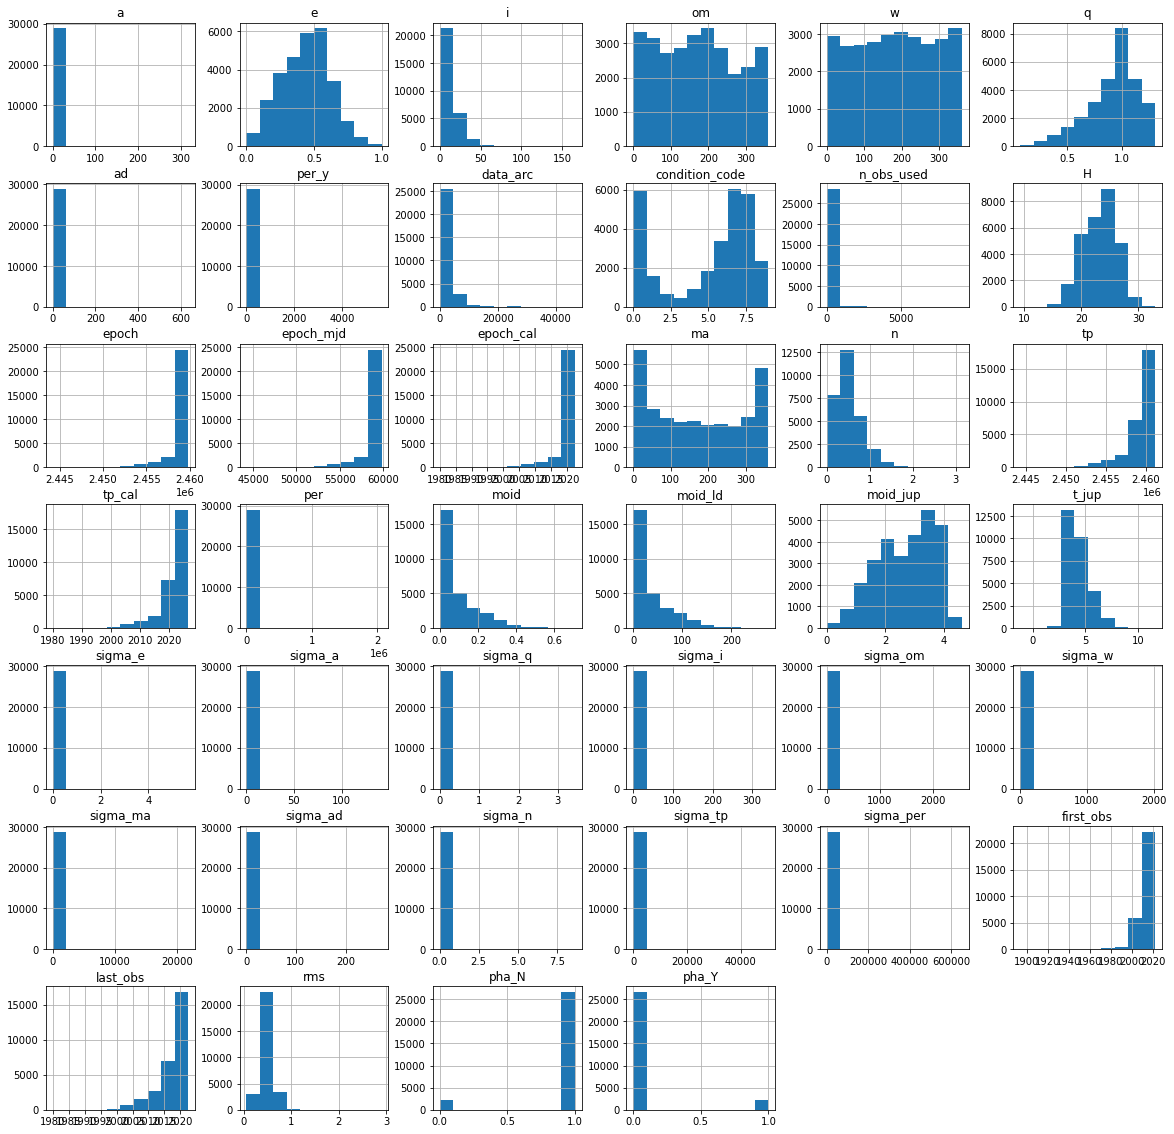

In [628]:
asteroids_viz = pd.get_dummies(asteroids, columns=['pha'])

asteroids_viz.hist(figsize=(20,20))
plt.show()

<AxesSubplot:>

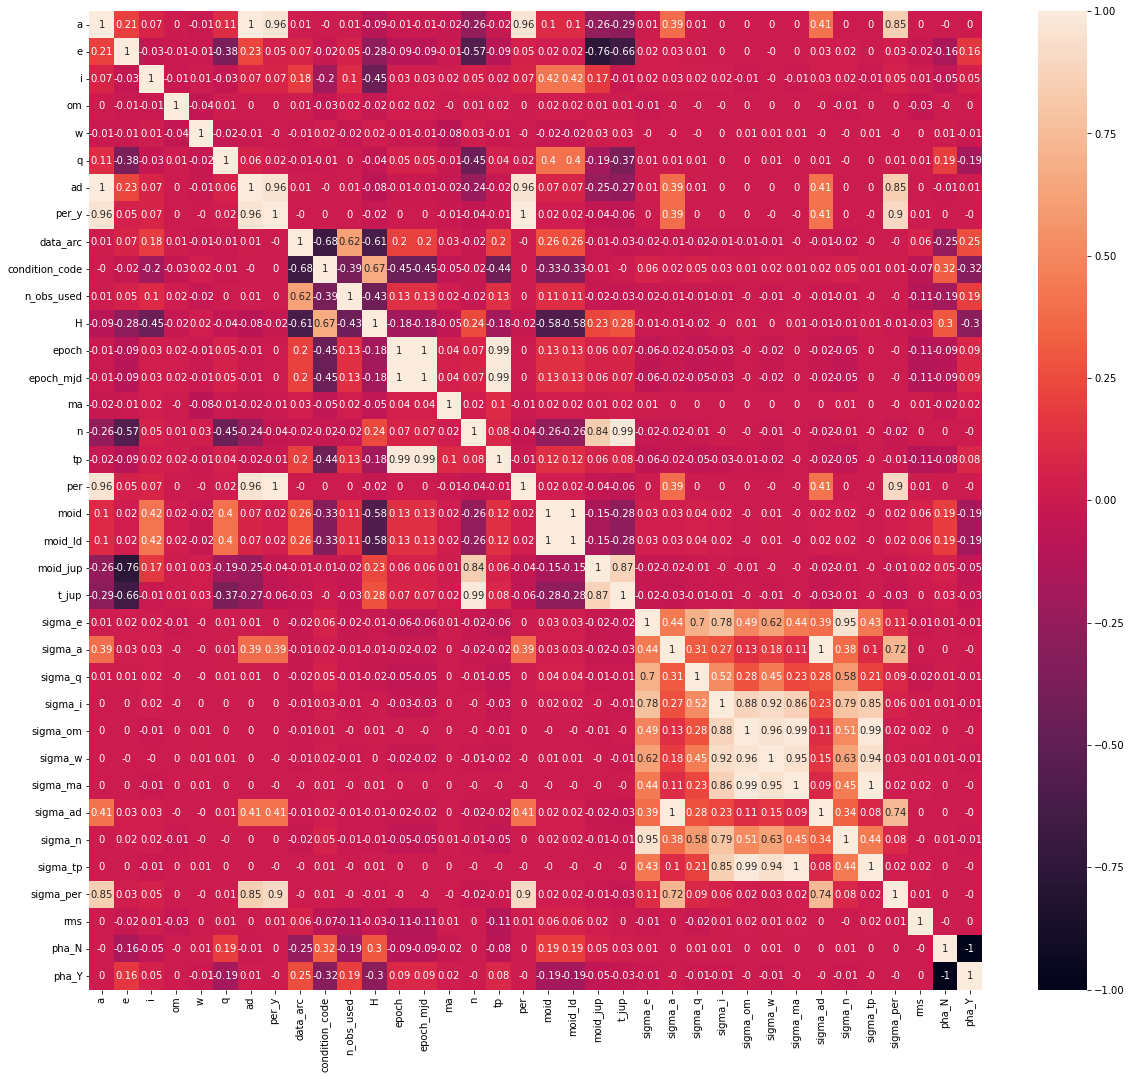

In [629]:
plt.subplots(figsize=(20,18))
heatmap(round(asteroids_viz.corr(), 2), annot=True)

Nie widać nigdzie większych korelacji pomiędzy atrybutem decyzyjnym a pozostałymi. Problem wydaje się być bardziej złożony i dopiero synergie (interakcje) pomiędzy atrybutami pozwolą na osiągnięcie satysfakcjonujących wyników.

### Processing danych

Utwórzmy kopię naszej ramki, na której będzie wykonywany processing. Jako, że modele, których będziemy używać nie są w stanie operować bezpośrednio na datach, użyjmy metody *toordinal*

In [630]:
asteroids1 = asteroids.copy()
asteroids1['epoch_cal'] = asteroids1['epoch_cal'].map(dt.datetime.toordinal)
asteroids1['tp_cal'] = asteroids1['tp_cal'].map(dt.datetime.toordinal)
asteroids1['first_obs'] = asteroids1['first_obs'].map(dt.datetime.toordinal)
asteroids1['last_obs'] = asteroids1['last_obs'].map(dt.datetime.toordinal)
asteroids1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28876 entries, 0 to 29122
Data columns (total 42 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   full_name       28876 non-null  object  
 1   a               28876 non-null  float64 
 2   e               28876 non-null  float64 
 3   i               28876 non-null  float64 
 4   om              28876 non-null  float64 
 5   w               28876 non-null  float64 
 6   q               28876 non-null  float64 
 7   ad              28876 non-null  float64 
 8   per_y           28876 non-null  float64 
 9   data_arc        28876 non-null  float64 
 10  condition_code  28876 non-null  float64 
 11  n_obs_used      28876 non-null  int64   
 12  H               28876 non-null  float64 
 13  pha             28876 non-null  category
 14  orbit_id        28876 non-null  category
 15  epoch           28876 non-null  float64 
 16  epoch_mjd       28876 non-null  int64   
 17  epoch_cal   

Niektóre kolumny zawierają bardzo duże oraz bardzo małe wartości. Ujednolićmy je w danych kolumnach za pomocą skalowania min-max. Z naszej ramki wybieramy tutaj jedynie kolumny numeryczne

In [631]:
to_scale = asteroids1.select_dtypes(include=['float64', 'int64'])
print(to_scale.columns)
print(to_scale.shape[0], asteroids.select_dtypes(exclude=['float64', 'int64']).shape[0])

Index(['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc',
       'condition_code', 'n_obs_used', 'H', 'epoch', 'epoch_mjd', 'epoch_cal',
       'ma', 'n', 'tp', 'tp_cal', 'per', 'moid', 'moid_ld', 'moid_jup',
       't_jup', 'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om',
       'sigma_w', 'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per',
       'first_obs', 'last_obs', 'rms'],
      dtype='object')
28876 28876


Używamy skalowania min-max z modułu sklearn.preprocessing

In [632]:
scaler = preprocessing.MinMaxScaler()
scaled = scaler.fit_transform(to_scale)
scaled = pd.DataFrame(scaled, columns=to_scale.columns)
scaled.drop_duplicates(inplace=True)
scaled.reset_index(drop=True, inplace=True)
scaled

,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,epoch,epoch_mjd,epoch_cal,ma,n,tp,tp_cal,per,moid,moid_ld,moid_jup,t_jup,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,first_obs,last_obs,rms
0,0.003144,0.221386,0.065374,0.845302,0.497029,0.864487,0.001784,0.000256,1.000000,0.000000,1.000000,0.045531,1.000000,1.000000,1.000000,0.996726,0.178128,0.915925,0.915925,0.000256,0.212385,0.212385,0.711523,0.451052,1.642572e-09,7.726102e-13,3.920112e-09,3.378055e-09,1.386950e-09,1.942071e-09,6.418849e-11,5.036856e-13,3.815861e-12,5.075822e-11,1.188360e-13,0.000000,0.973921,0.086554
1,0.006863,0.547846,0.069893,0.510729,0.434009,0.914265,0.005412,0.000702,0.867779,0.000000,0.219264,0.267285,1.000000,1.000000,1.000000,0.900563,0.073214,0.924971,0.924945,0.000702,0.284171,0.284171,0.307127,0.338737,3.771606e-09,1.740192e-11,1.659313e-08,8.267570e-09,5.892243e-09,7.524442e-09,1.191083e-10,1.410587e-11,3.144850e-11,2.310658e-10,3.405635e-12,0.139361,0.998970,0.125861
2,0.006345,0.571604,0.056718,0.306731,0.973564,0.806325,0.005103,0.000632,0.811447,0.000000,0.290160,0.194351,1.000000,1.000000,1.000000,0.381443,0.080630,0.883859,0.883851,0.000632,0.116401,0.116401,0.285396,0.344973,4.730723e-09,2.052384e-11,1.941236e-08,9.151744e-09,9.100414e-09,1.163681e-08,1.665773e-10,1.688109e-11,4.594278e-11,2.721910e-10,3.884147e-12,0.188609,0.979008,0.123044
3,0.006954,0.533872,0.161147,0.598648,0.367911,0.955048,0.005424,0.000714,0.764861,0.000000,0.826101,0.000000,1.000000,1.000000,1.000000,0.516405,0.072021,0.961133,0.961087,0.000714,0.487122,0.487122,0.422535,0.330398,1.947732e-09,1.283625e-11,8.647772e-09,1.422983e-09,4.071409e-10,5.350944e-10,6.902114e-11,1.032737e-11,2.089348e-11,1.477424e-10,2.532260e-12,0.240838,0.997296,0.110600
4,0.004597,0.435986,0.071749,0.475898,0.073966,0.823121,0.003320,0.000415,0.703592,0.000000,0.063664,0.343592,1.000000,1.000000,1.000000,0.931171,0.117972,0.919741,0.919698,0.000415,0.151323,0.151323,0.478334,0.388620,5.861803e-09,6.385239e-12,1.866234e-08,1.305555e-08,8.245926e-09,1.119288e-08,3.564902e-10,4.829041e-12,2.529862e-11,4.186725e-10,1.072784e-12,0.298238,0.987186,0.136493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28871,0.005376,0.635966,0.033768,0.288767,0.715666,0.586460,0.004559,0.000508,0.000408,0.777778,0.001534,0.513111,1.000000,1.000000,1.000000,0.986854,0.098391,0.916703,0.916691,0.000508,0.031217,0.031217,0.421108,0.358535,1.058274e-04,2.537731e-05,7.318470e-06,9.858535e-06,2.181345e-06,9.742821e-06,8.237486e-07,2.163136e-05,8.905520e-05,3.949413e-07,4.469439e-06,0.999574,0.999936,0.137582
28872,0.003442,0.335048,0.037173,0.411478,0.662478,0.781664,0.002243,0.000287,0.000021,1.000000,0.001863,0.481956,0.996855,0.996855,0.996855,0.757073,0.162112,0.923033,0.923000,0.000287,0.114051,0.114051,0.733914,0.434840,1.110498e-03,6.054625e-05,1.392112e-03,1.878833e-04,1.741016e-04,3.307684e-04,5.397524e-05,4.217173e-05,4.881742e-04,2.678508e-05,9.028984e-06,0.999979,1.000000,0.087460
28873,0.001255,0.201042,0.087894,0.265284,0.970355,0.500100,0.000600,0.000085,0.000000,0.777778,0.004274,0.621290,1.000000,1.000000,1.000000,0.687242,0.393759,0.921167,0.921172,0.000085,0.017127,0.017127,0.891254,0.625877,5.205473e-05,1.285231e-06,1.162151e-04,9.947470e-05,1.697699e-06,1.368673e-05,2.085372e-06,8.059541e-07,4.546397e-05,1.009278e-06,1.425878e-07,1.000000,1.000000,0.150086
28874,0.001528,0.128121,0.142606,0.262629,0.894080,0.612007,0.000656,0.000107,0.000000,0.777778,0.003835,0.574747,1.000000,1.000000,1.000000,0.763982,0.340925,0.920478,0.920465,0.000107,0.026850,0.026850,0.895571,0.583009,4.481815e-05,2.950021e-06,1.598421e-04,2.675881e-04,1.700612e-06,9.192386e-05,8.948187e-06,1.738556e-06,8.208194e-05,2.861286e-06,3.433843e-07,1.000000,1.000000,0.103800


Następnie wybieramy z ramki wartości nienumeryczne i łączymy obie ramki. Otrzymujemy ramkę z ujednoliconymi wartościami

In [633]:
asteroids1 = asteroids1.select_dtypes(exclude=['float64', 'int64'])
asteroids1.drop_duplicates(inplace=True)
asteroids1.reset_index(drop=True, inplace=True)

In [634]:
asteroids1 = pd.concat([asteroids1, scaled], axis=1)
asteroids1.drop_duplicates(inplace=True)
asteroids1.reset_index(drop=True, inplace=True)
asteroids1

,full_name,pha,orbit_id,class,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,epoch,epoch_mjd,epoch_cal,ma,n,tp,tp_cal,per,moid,moid_ld,moid_jup,t_jup,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,first_obs,last_obs,rms
0,433 Eros (A898 PA),N,Other,AMO,0.003144,0.221386,0.065374,0.845302,0.497029,0.864487,0.001784,0.000256,1.000000,0.000000,1.000000,0.045531,1.000000,1.000000,1.000000,0.996726,0.178128,0.915925,0.915925,0.000256,0.212385,0.212385,0.711523,0.451052,1.642572e-09,7.726102e-13,3.920112e-09,3.378055e-09,1.386950e-09,1.942071e-09,6.418849e-11,5.036856e-13,3.815861e-12,5.075822e-11,1.188360e-13,0.000000,0.973921,0.086554
1,719 Albert (A911 TB),N,Other,AMO,0.006863,0.547846,0.069893,0.510729,0.434009,0.914265,0.005412,0.000702,0.867779,0.000000,0.219264,0.267285,1.000000,1.000000,1.000000,0.900563,0.073214,0.924971,0.924945,0.000702,0.284171,0.284171,0.307127,0.338737,3.771606e-09,1.740192e-11,1.659313e-08,8.267570e-09,5.892243e-09,7.524442e-09,1.191083e-10,1.410587e-11,3.144850e-11,2.310658e-10,3.405635e-12,0.139361,0.998970,0.125861
2,887 Alinda (A918 AA),N,Other,AMO,0.006345,0.571604,0.056718,0.306731,0.973564,0.806325,0.005103,0.000632,0.811447,0.000000,0.290160,0.194351,1.000000,1.000000,1.000000,0.381443,0.080630,0.883859,0.883851,0.000632,0.116401,0.116401,0.285396,0.344973,4.730723e-09,2.052384e-11,1.941236e-08,9.151744e-09,9.100414e-09,1.163681e-08,1.665773e-10,1.688109e-11,4.594278e-11,2.721910e-10,3.884147e-12,0.188609,0.979008,0.123044
3,1036 Ganymed (A924 UB),N,Other,AMO,0.006954,0.533872,0.161147,0.598648,0.367911,0.955048,0.005424,0.000714,0.764861,0.000000,0.826101,0.000000,1.000000,1.000000,1.000000,0.516405,0.072021,0.961133,0.961087,0.000714,0.487122,0.487122,0.422535,0.330398,1.947732e-09,1.283625e-11,8.647772e-09,1.422983e-09,4.071409e-10,5.350944e-10,6.902114e-11,1.032737e-11,2.089348e-11,1.477424e-10,2.532260e-12,0.240838,0.997296,0.110600
4,1221 Amor (1932 EA1),N,111,AMO,0.004597,0.435986,0.071749,0.475898,0.073966,0.823121,0.003320,0.000415,0.703592,0.000000,0.063664,0.343592,1.000000,1.000000,1.000000,0.931171,0.117972,0.919741,0.919698,0.000415,0.151323,0.151323,0.478334,0.388620,5.861803e-09,6.385239e-12,1.866234e-08,1.305555e-08,8.245926e-09,1.119288e-08,3.564902e-10,4.829041e-12,2.529862e-11,4.186725e-10,1.072784e-12,0.298238,0.987186,0.136493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28871,(2022 MN),Y,JPL 1,APO,0.005376,0.635966,0.033768,0.288767,0.715666,0.586460,0.004559,0.000508,0.000408,0.777778,0.001534,0.513111,1.000000,1.000000,1.000000,0.986854,0.098391,0.916703,0.916691,0.000508,0.031217,0.031217,0.421108,0.358535,1.058274e-04,2.537731e-05,7.318470e-06,9.858535e-06,2.181345e-06,9.742821e-06,8.237486e-07,2.163136e-05,8.905520e-05,3.949413e-07,4.469439e-06,0.999574,0.999936,0.137582
28872,(2022 MO),N,JPL 1,AMO,0.003442,0.335048,0.037173,0.411478,0.662478,0.781664,0.002243,0.000287,0.000021,1.000000,0.001863,0.481956,0.996855,0.996855,0.996855,0.757073,0.162112,0.923033,0.923000,0.000287,0.114051,0.114051,0.733914,0.434840,1.110498e-03,6.054625e-05,1.392112e-03,1.878833e-04,1.741016e-04,3.307684e-04,5.397524e-05,4.217173e-05,4.881742e-04,2.678508e-05,9.028984e-06,0.999979,1.000000,0.087460
28873,(2022 MP),N,JPL 1,ATE,0.001255,0.201042,0.087894,0.265284,0.970355,0.500100,0.000600,0.000085,0.000000,0.777778,0.004274,0.621290,1.000000,1.000000,1.000000,0.687242,0.393759,0.921167,0.921172,0.000085,0.017127,0.017127,0.891254,0.625877,5.205473e-05,1.285231e-06,1.162151e-04,9.947470e-05,1.697699e-06,1.368673e-05,2.085372e-06,8.059541e-07,4.546397e-05,1.009278e-06,1.425878e-07,1.000000,1.000000,0.150086
28874,(2022 MQ),N,JPL 1,ATE,0.001528,0.128121,0.142606,0.262629,0.894080,0.612007,0.000656,0.000107,0.000000,0.777778,0.003835,0.574747,1.000000,1.000000,1.000000,0.763982,0.340925,0.920478,0.920465,0.000

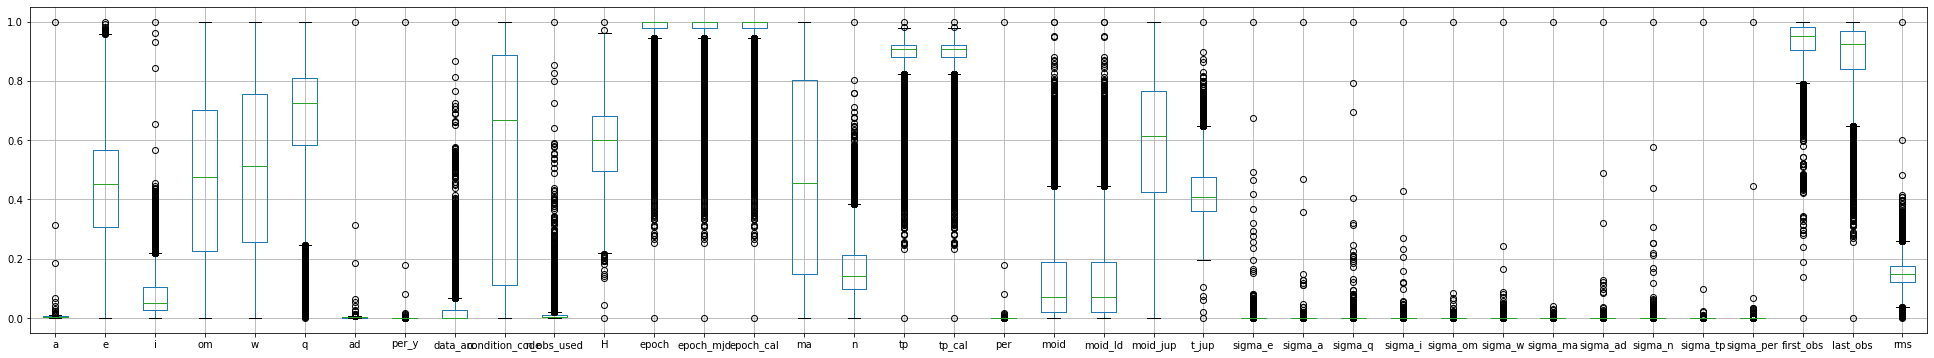

In [635]:
asteroids1.boxplot(figsize=(34,6))
plt.show()

Praktycznie wszędzie jest bardzo dużo wartości odstających, ale jak wiadomo asteroidy mogą być bardzo różne

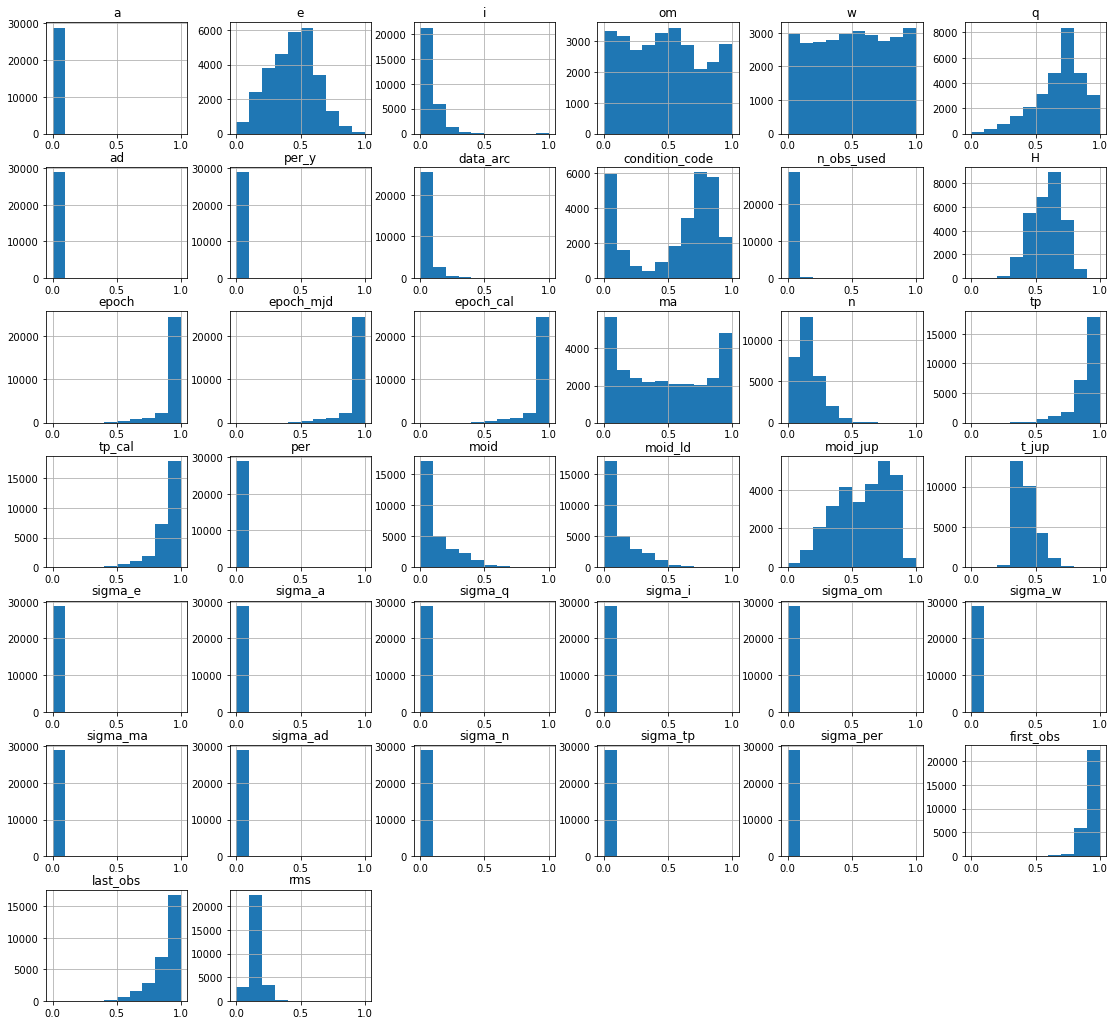

In [636]:
asteroids1.hist(figsize=(19,18))
plt.show()

*orbit_id* oraz *class* są kolumnami o typie kategorycznym. Do modelowania przy pomocy sklearn, który na takim typie danych nie pracuje (prócz kolumny przewidywanej; czasami niejawnie stosuje One-Hot Encoding w zależności od modelu), zastosujmy takie kodowanie sami za pomocą funkcji *get_dummies* na tych kolumnach

In [637]:
asteroids1 = pd.get_dummies(asteroids1, columns=['orbit_id', 'class'])
asteroids1.head()

,full_name,pha,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,epoch,epoch_mjd,epoch_cal,ma,n,tp,tp_cal,per,moid,moid_ld,moid_jup,t_jup,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,first_obs,last_obs,rms,orbit_id_1,orbit_id_10,orbit_id_101,orbit_id_102,orbit_id_104,orbit_id_105,orbit_id_106,orbit_id_107,orbit_id_11,orbit_id_111,orbit_id_113,orbit_id_12,orbit_id_129,orbit_id_13,orbit_id_14,orbit_id_149,orbit_id_15,orbit_id_16,orbit_id_17,orbit_id_18,orbit_id_19,orbit_id_2,orbit_id_20,orbit_id_21,orbit_id_22,orbit_id_23,orbit_id_24,orbit_id_25,orbit_id_26,orbit_id_27,orbit_id_28,orbit_id_29,orbit_id_3,orbit_id_30,orbit_id_31,orbit_id_32,orbit_id_33,orbit_id_34,orbit_id_35,orbit_id_36,orbit_id_37,orbit_id_38,orbit_id_39,orbit_id_4,orbit_id_40,orbit_id_41,orbit_id_42,orbit_id_43,orbit_id_44,orbit_id_45,orbit_id_46,orbit_id_47,orbit_id_48,orbit_id_49,orbit_id_5,orbit_id_50,orbit_id_51,orbit_id_52,orbit_id_53,orbit_id_54,orbit_id_55,orbit_id_56,orbit_id_57,orbit_id_58,orbit_id_59,orbit_id_6,orbit_id_60,orbit_id_61,orbit_id_62,orbit_id_63,orbit_id_64,orbit_id_65,orbit_id_66,orbit_id_67,orbit_id_68,orbit_id_69,orbit_id_7,orbit_id_70,orbit_id_71,orbit_id_72,orbit_id_73,orbit_id_74,orbit_id_75,orbit_id_76,orbit_id_77,orbit_id_78,orbit_id_79,orbit_id_8,orbit_id_80,orbit_id_81,orbit_id_82,orbit_id_83,orbit_id_84,orbit_id_85,orbit_id_86,orbit_id_87,orbit_id_88,orbit_id_89,orbit_id_9,orbit_id_90,orbit_id_91,orbit_id_92,orbit_id_93,orbit_id_94,orbit_id_95,orbit_id_96,orbit_id_97,orbit_id_98,orbit_id_99,orbit_id_JPL 1,orbit_id_JPL 10,orbit_id_JPL 11,orbit_id_JPL 12,orbit_id_JPL 13,orbit_id_JPL 14,orbit_id_JPL 15,orbit_id_JPL 16,orbit_id_JPL 17,orbit_id_JPL 18,orbit_id_JPL 19,orbit_id_JPL 2,orbit_id_JPL 3,orbit_id_JPL 4,orbit_id_JPL 5,orbit_id_JPL 6,orbit_id_JPL 7,orbit_id_JPL 8,orbit_id_JPL 9,orbit_id_Other,class_AMO,class_APO,class_ATE,class_IEO
0,433 Eros (A898 PA),N,0.003144,0.221386,0.065374,0.845302,0.497029,0.864487,0.001784,0.000256,1.000000,0.0,1.000000,0.045531,1.0,1.0,1.0,0.996726,0.178128,0.915925,0.915925,0.000256,0.212385,0.212385,0.711523,0.451052,1.642572e-09,7.726102e-13,3.920112e-09,3.378055e-09,1.386950e-09,1.942071e-09,6.418849e-11,5.036856e-13,3.815861e-12,5.075822e-11,1.188360e-13,0.000000,0.973921,0.086554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,719 Albert (A911 TB),N,0.006863,0.547846,0.069893,0.510729,0.434009,0.914265,0.005412,0.000702,0.867779,0.0,0.219264,0.267285,1.0,1.0,1.0,0.900563,0.073214,0.924971,0.924945,0.000702,0.284171,0.284171,0.307127,0.338737,3.771606e-09,1.740192e-11,1.659313e-08,8.267570e-09,5.892243e-09,7.524442e-09,1.191083e-10,1.410587e-11,3.144850e-11,2.310658e-10,3.405635e-12,0.139361,0.998970,0.125861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,887 Alinda (A918 AA),N,0.006345,0.571604,0.056718,0.306731,0.973564,0.806325,0.005103,0.000632,0.811447,0.0,0.290160,0.194351,1.0,1.0,1.0,0.381443,0.080630,0.883859,0.883851,0.000632,0.116401,0.116401,0.285396,0.344973,4.730723e-09,2.052384e-11,1.941236e-08,9.151744e-09,9.100414e-09,1.163681e-08,1.665773e-10,1.688109e-11,4.594278e-11,2.721910e-10,3.884147e-12,0.188609,0.979008,0.123044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,1036 Ganymed (A924 UB),N,0.006954,0.533872,0.161147,0.598648,0.367911,0.955048,0.005424,0.000714,0.764861,

In [638]:
asteroids1.select_dtypes(exclude=['float64', 'int64', 'uint8']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28876 entries, 0 to 28875
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   full_name  28876 non-null  object  
 1   pha        28876 non-null  category
dtypes: category(1), object(1)
memory usage: 254.0+ KB


In [639]:
asteroids1 = asteroids1.reset_index(drop=True)
asteroids1.head()

,full_name,pha,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,epoch,epoch_mjd,epoch_cal,ma,n,tp,tp_cal,per,moid,moid_ld,moid_jup,t_jup,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,first_obs,last_obs,rms,orbit_id_1,orbit_id_10,orbit_id_101,orbit_id_102,orbit_id_104,orbit_id_105,orbit_id_106,orbit_id_107,orbit_id_11,orbit_id_111,orbit_id_113,orbit_id_12,orbit_id_129,orbit_id_13,orbit_id_14,orbit_id_149,orbit_id_15,orbit_id_16,orbit_id_17,orbit_id_18,orbit_id_19,orbit_id_2,orbit_id_20,orbit_id_21,orbit_id_22,orbit_id_23,orbit_id_24,orbit_id_25,orbit_id_26,orbit_id_27,orbit_id_28,orbit_id_29,orbit_id_3,orbit_id_30,orbit_id_31,orbit_id_32,orbit_id_33,orbit_id_34,orbit_id_35,orbit_id_36,orbit_id_37,orbit_id_38,orbit_id_39,orbit_id_4,orbit_id_40,orbit_id_41,orbit_id_42,orbit_id_43,orbit_id_44,orbit_id_45,orbit_id_46,orbit_id_47,orbit_id_48,orbit_id_49,orbit_id_5,orbit_id_50,orbit_id_51,orbit_id_52,orbit_id_53,orbit_id_54,orbit_id_55,orbit_id_56,orbit_id_57,orbit_id_58,orbit_id_59,orbit_id_6,orbit_id_60,orbit_id_61,orbit_id_62,orbit_id_63,orbit_id_64,orbit_id_65,orbit_id_66,orbit_id_67,orbit_id_68,orbit_id_69,orbit_id_7,orbit_id_70,orbit_id_71,orbit_id_72,orbit_id_73,orbit_id_74,orbit_id_75,orbit_id_76,orbit_id_77,orbit_id_78,orbit_id_79,orbit_id_8,orbit_id_80,orbit_id_81,orbit_id_82,orbit_id_83,orbit_id_84,orbit_id_85,orbit_id_86,orbit_id_87,orbit_id_88,orbit_id_89,orbit_id_9,orbit_id_90,orbit_id_91,orbit_id_92,orbit_id_93,orbit_id_94,orbit_id_95,orbit_id_96,orbit_id_97,orbit_id_98,orbit_id_99,orbit_id_JPL 1,orbit_id_JPL 10,orbit_id_JPL 11,orbit_id_JPL 12,orbit_id_JPL 13,orbit_id_JPL 14,orbit_id_JPL 15,orbit_id_JPL 16,orbit_id_JPL 17,orbit_id_JPL 18,orbit_id_JPL 19,orbit_id_JPL 2,orbit_id_JPL 3,orbit_id_JPL 4,orbit_id_JPL 5,orbit_id_JPL 6,orbit_id_JPL 7,orbit_id_JPL 8,orbit_id_JPL 9,orbit_id_Other,class_AMO,class_APO,class_ATE,class_IEO
0,433 Eros (A898 PA),N,0.003144,0.221386,0.065374,0.845302,0.497029,0.864487,0.001784,0.000256,1.000000,0.0,1.000000,0.045531,1.0,1.0,1.0,0.996726,0.178128,0.915925,0.915925,0.000256,0.212385,0.212385,0.711523,0.451052,1.642572e-09,7.726102e-13,3.920112e-09,3.378055e-09,1.386950e-09,1.942071e-09,6.418849e-11,5.036856e-13,3.815861e-12,5.075822e-11,1.188360e-13,0.000000,0.973921,0.086554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,719 Albert (A911 TB),N,0.006863,0.547846,0.069893,0.510729,0.434009,0.914265,0.005412,0.000702,0.867779,0.0,0.219264,0.267285,1.0,1.0,1.0,0.900563,0.073214,0.924971,0.924945,0.000702,0.284171,0.284171,0.307127,0.338737,3.771606e-09,1.740192e-11,1.659313e-08,8.267570e-09,5.892243e-09,7.524442e-09,1.191083e-10,1.410587e-11,3.144850e-11,2.310658e-10,3.405635e-12,0.139361,0.998970,0.125861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,887 Alinda (A918 AA),N,0.006345,0.571604,0.056718,0.306731,0.973564,0.806325,0.005103,0.000632,0.811447,0.0,0.290160,0.194351,1.0,1.0,1.0,0.381443,0.080630,0.883859,0.883851,0.000632,0.116401,0.116401,0.285396,0.344973,4.730723e-09,2.052384e-11,1.941236e-08,9.151744e-09,9.100414e-09,1.163681e-08,1.665773e-10,1.688109e-11,4.594278e-11,2.721910e-10,3.884147e-12,0.188609,0.979008,0.123044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,1036 Ganymed (A924 UB),N,0.006954,0.533872,0.161147,0.598648,0.367911,0.955048,0.005424,0.000714,0.764861,

In [640]:
asteroids1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28876 entries, 0 to 28875
Columns: 173 entries, full_name to class_IEO
dtypes: category(1), float64(38), object(1), uint8(133)
memory usage: 12.3+ MB


Mamy już ramkę, która jest przygotowana do modelowania. Wszystko wygląda w porządku, więc przejdźmy dalej

## Modelowanie

Utwórzmy uniwersalną funkcję, która na podstawie każdego modelu zwróci nam rezultaty predykcji

In [641]:
def metricCalculation(y_test, pred, model):
    accuracy = metrics.accuracy_score(y_test, pred)
    accuracy = round(accuracy*100, 2)
    print('Accuracy:', accuracy)

    precision = metrics.precision_score(y_test, pred, average='macro')
    precision = round(precision*100, 2)
    print('Precision:', precision)

    recall = metrics.recall_score(y_test, pred, average='macro')
    recall = round(recall*100, 2)
    print('Recall:', recall)

    f1 = metrics.f1_score(y_test, pred, average='macro')
    f1 = round(f1*100, 2)
    print('F1:', f1)

    tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred, normalize='true').ravel()
    tn = round(tn*100, 2)
    fp = round(fp*100, 2)
    fn = round(fn*100, 2)
    tp = round(tp*100, 2)
    print('TN: ', tn, ', FP: ', fp, ', FN: ', fn, ', TP: ', tp, sep='')

    cm = metrics.confusion_matrix(y_test, pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    heatmap(cmn, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel('actual')
    plt.xlabel('predicted')
    plt.title(model)
    plt.show(block=False)

    return {'accuracy':accuracy, 'precision':precision, 'recall':recall, 'f1':f1,
            'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp, 'model':model}

### Przed oversamplingiem

Zacznijmy od regresji logistycznej na najważniejszych atrybutach - moid + H

In [642]:
rnd_seed = 26549

Rozdzielmy kolumnę dezycyjną od pozostałych kolumn. Podzielmy dane na zbiory treningowe i testowe. Następnie dopasujmy dane do modelu i dokonajmy predykcji

#### Logistic Regression - moid + H

Accuracy: 95.3
Precision: 91.16
Recall: 74.4
F1: 80.23
TN: 99.33, FP: 0.67, FN: 50.52, TP: 49.48


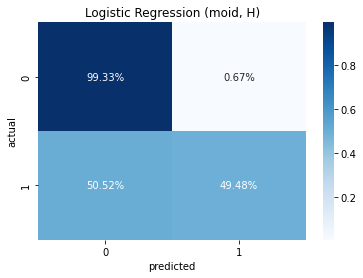

In [643]:
X = asteroids1[['moid', 'H']]
y = asteroids1['pha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rnd_seed)

lr_base = LogisticRegression(max_iter=10000, n_jobs=os.cpu_count())
lr_base.fit(X_train, y_train)
lr_base_pred = lr_base.predict(X_test)
lr_base_results = metricCalculation(y_test, lr_base_pred, 'Logistic Regression (moid, H)')

Jak widać, dla klasy *pha* o wartości *Y* regresja logistyczna nie poradziła sobie zbyt dobrze - wyniki to prawie równe 50/50. Jednak dla *pha* o wartości *N*, ze względu na sporo większą liczbę obserwacji tej klasy, model uzyskał całkiem dobre wyniki. Nastąpiło tu nadmierne dopasowanie (overfitting) dla klasy *N*

Może regresja logistyczna ze wszystkimi atrybutami poradzi sobie lepiej? Tutaj odrzucamy tylko kolumnę *full_name* - nie jest ona przydatna w predykcji

#### Logistic Regression - wszystkie atrybuty

Accuracy: 96.13
Precision: 89.98
Recall: 82.2
F1: 85.58
TN: 98.81, FP: 1.19, FN: 34.42, TP: 65.58


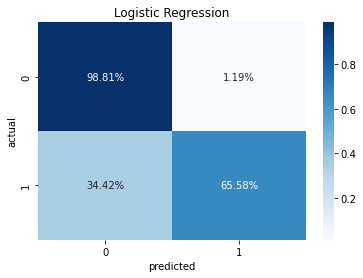

In [644]:
X = asteroids1.drop(['pha', 'full_name'], axis=1)
y = asteroids1['pha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rnd_seed)

lr_full = LogisticRegression(max_iter=10000, n_jobs=os.cpu_count())
lr_full.fit(X_train, y_train)
lr_full_pred = lr_full.predict(X_test)
lr_full_results = metricCalculation(y_test, lr_full_pred, 'Logistic Regression')

Tutaj wyniki są już lepsze, jednak wciąż nie są one satysfakcjonujące. Sprawdźmy jakie atrybuty były najistotniejsze w nauce tego modelu

#### Logistic Regression - najważniejsze atrybuty

In [645]:
feature_imp_lr = pd.DataFrame(
    lr_full.coef_[0], index=X_train.columns,
    columns=['Importance'])
feature_imp_lr = feature_imp_lr.abs()
feature_imp_lr = feature_imp_lr.sort_values(by='Importance', ascending=False)
feature_imp_lr.round(6).head(20)

,Importance
H,15.737267
moid,14.824519
moid_ld,14.824519
condition_code,2.178538
data_arc,1.865778
first_obs,1.667629
orbit_id_2,1.444104
i,1.241887
orbit_id_62,1.221512
orbit_id_JPL 5,1.179691


Tak jak się spodziewaliśmy, *H* oraz *moid* miały największe znaczenie. Weźmy kilka najistotniejszych atrybutów i spróbujmy zbudować na nich kolejny model regresji

In [646]:
important_features_lr = feature_imp_lr.loc[feature_imp_lr['Importance'] > 1].index
important_features_lr

Index(['H', 'moid', 'moid_ld', 'condition_code', 'data_arc', 'first_obs',
       'orbit_id_2', 'i', 'orbit_id_62', 'orbit_id_JPL 5', 'n_obs_used',
       'orbit_id_4', 'orbit_id_82', 'rms', 'orbit_id_85', 'orbit_id_JPL 6',
       'orbit_id_JPL 7'],
      dtype='object')

In [647]:
important_features_lr = list(important_features_lr)
if 'pha' not in important_features_lr:
    important_features_lr.append('pha')
asteroids2_lr = asteroids1[important_features_lr]
asteroids2_lr

,H,moid,moid_ld,condition_code,data_arc,first_obs,orbit_id_2,i,orbit_id_62,orbit_id_JPL 5,n_obs_used,orbit_id_4,orbit_id_82,rms,orbit_id_85,orbit_id_JPL 6,orbit_id_JPL 7,pha
0,0.045531,0.212385,0.212385,0.000000,1.000000,0.000000,0,0.065374,0,0,1.000000,0,0,0.086554,0,0,0,N
1,0.267285,0.284171,0.284171,0.000000,0.867779,0.139361,0,0.069893,0,0,0.219264,0,0,0.125861,0,0,0,N
2,0.194351,0.116401,0.116401,0.000000,0.811447,0.188609,0,0.056718,0,0,0.290160,0,0,0.123044,0,0,0,N
3,0.000000,0.487122,0.487122,0.000000,0.764861,0.240838,0,0.161147,0,0,0.826101,0,0,0.110600,0,0,0,N
4,0.343592,0.151323,0.151323,0.000000,0.703592,0.298238,0,0.071749,0,0,0.063664,0,0,0.136493,0,0,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28871,0.513111,0.031217,0.031217,0.777778,0.000408,0.999574,0,0.033768,0,0,0.001534,0,0,0.137582,0,0,0,Y
28872,0.481956,0.114051,0.114051,1.000000,0.000021,0.999979,0,0.037173,0,0,0.001863,0,0,0.087460,0,0,0,N
28873,0.621290,0.017127,0.017127,0.777778,0.000000,1.000000,0,0.087894,0,0,0.004274,0,0,0.150086,0,0,0,N
28874,0.574747,0.026850,0.026850,0.777778,0.000000,1.000000,0,0.142606,0,0,0.003835,0,0,0.103800,0,0,0,N


Accuracy: 96.38
Precision: 91.97
Recall: 82.04
F1: 86.2
TN: 99.14, FP: 0.86, FN: 35.06, TP: 64.94


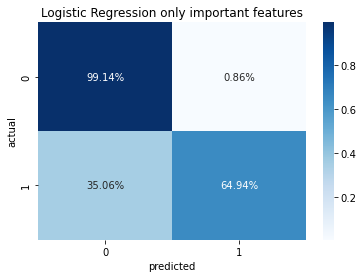

In [648]:
X = asteroids2_lr.drop(['pha'], axis=1)
y = asteroids2_lr['pha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rnd_seed)

lr_imp = LogisticRegression(max_iter=10000, n_jobs=os.cpu_count())
lr_imp.fit(X_train, y_train)
lr_imp_pred = lr_imp.predict(X_test)
lr_imp_results = metricCalculation(y_test, lr_imp_pred, 'Logistic Regression only important features')

Wyniki są porównywalne, jednak nieco gorsze. Jak z tym problem poradzi sobie klasyfikator lasów losowych?

#### RandomForest Classifier

Accuracy: 99.57
Precision: 99.46
Recall: 97.63
F1: 98.52
TN: 99.94, FP: 0.06, FN: 4.68, TP: 95.32


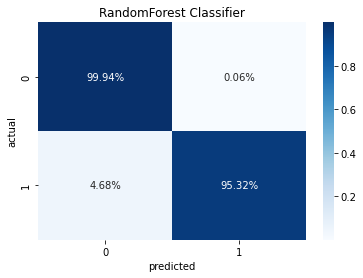

In [649]:
X = asteroids1.drop(['pha', 'full_name'], axis=1)
y = asteroids1['pha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rnd_seed)

rf = RandomForestClassifier(n_estimators=150, random_state=rnd_seed, n_jobs=os.cpu_count())
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_results = metricCalculation(y_test, rf_pred, 'RandomForest Classifier')

Wyniki są naprawdę zadowalające, jednak sprawdźmy czy można je polepszyć stosując tylko najważniejsze atrybuty

#### RandomForest Classifier - najważniejsze atrybuty

In [650]:
feature_imp_rf = pd.DataFrame(rf.feature_importances_, index=X_train.columns,
    columns=['Importance'])
feature_imp_rf = feature_imp_rf.abs()
feature_imp_rf = feature_imp_rf.sort_values(by='Importance', ascending=False)
feature_imp_rf.round(6).head(25)

,Importance
moid,0.176480
H,0.171293
moid_ld,0.160394
data_arc,0.052171
n_obs_used,0.040499
condition_code,0.035506
i,0.026429
sigma_e,0.023984
q,0.023900
sigma_n,0.021025


Przy nauce klasyfikatora lasów losowych atrybuty wyglądają już bardziej sensownie - są tutaj atrybuty *moid*, *H* oraz *data_arc*, które wyglądały na najbardziej obiecujące. Wybierzmy kilka z nich

In [651]:
important_features_rf = feature_imp_rf.loc[feature_imp_rf['Importance'] > 0.009].index
important_features_rf

Index(['moid', 'H', 'moid_ld', 'data_arc', 'n_obs_used', 'condition_code', 'i',
       'sigma_e', 'q', 'sigma_n', 'e', 'first_obs', 't_jup', 'class_APO', 'ad',
       'class_AMO', 'a', 'per_y', 'per', 'n', 'moid_jup', 'last_obs'],
      dtype='object')

In [652]:
important_features_rf = list(important_features_rf)
if 'pha' not in important_features_rf:
    important_features_rf.append('pha')
asteroids2_rf = asteroids1[important_features_rf]
asteroids2_rf

,moid,H,moid_ld,data_arc,n_obs_used,condition_code,i,sigma_e,q,sigma_n,e,first_obs,t_jup,class_APO,ad,class_AMO,a,per_y,per,n,moid_jup,last_obs,pha
0,0.212385,0.045531,0.212385,1.000000,1.000000,0.000000,0.065374,1.642572e-09,0.864487,3.815861e-12,0.221386,0.000000,0.451052,0,0.001784,1,0.003144,0.000256,0.000256,0.178128,0.711523,0.973921,N
1,0.284171,0.267285,0.284171,0.867779,0.219264,0.000000,0.069893,3.771606e-09,0.914265,3.144850e-11,0.547846,0.139361,0.338737,0,0.005412,1,0.006863,0.000702,0.000702,0.073214,0.307127,0.998970,N
2,0.116401,0.194351,0.116401,0.811447,0.290160,0.000000,0.056718,4.730723e-09,0.806325,4.594278e-11,0.571604,0.188609,0.344973,0,0.005103,1,0.006345,0.000632,0.000632,0.080630,0.285396,0.979008,N
3,0.487122,0.000000,0.487122,0.764861,0.826101,0.000000,0.161147,1.947732e-09,0.955048,2.089348e-11,0.533872,0.240838,0.330398,0,0.005424,1,0.006954,0.000714,0.000714,0.072021,0.422535,0.997296,N
4,0.151323,0.343592,0.151323,0.703592,0.063664,0.000000,0.071749,5.861803e-09,0.823121,2.529862e-11,0.435986,0.298238,0.388620,0,0.003320,1,0.004597,0.000415,0.000415,0.117972,0.478334,0.987186,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28871,0.031217,0.513111,0.031217,0.000408,0.001534,0.777778,0.033768,1.058274e-04,0.586460,8.905520e-05,0.635966,0.999574,0.358535,1,0.004559,0,0.005376,0.000508,0.000508,0.098391,0.421108,0.999936,Y
28872,0.114051,0.481956,0.114051,0.000021,0.001863,1.000000,0.037173,1.110498e-03,0.781664,4.881742e-04,0.335048,0.999979,0.434840,0,0.002243,1,0.003442,0.000287,0.000287,0.162112,0.733914,1.000000,N
28873,0.017127,0.621290,0.017127,0.000000,0.004274,0.777778,0.087894,5.205473e-05,0.500100,4.546397e-05,0.201042,1.000000,0.625877,0,0.000600,0,0.001255,0.000085,0.000085,0.393759,0.891254,1.000000,N
28874,0.026850,0.574747,0.026850,0.000000,0.003835,0.777778,0.142606,4.481815e-05,0.612007,8.208194e-05,0.128121,1.000000,0.583009,0,0.000656,0,0.001528,0.000107,0.000107,0.340925,0.895571,1.000000,N


Accuracy: 99.81
Precision: 99.36
Recall: 99.36
F1: 99.36
TN: 99.9, FP: 0.1, FN: 1.17, TP: 98.83


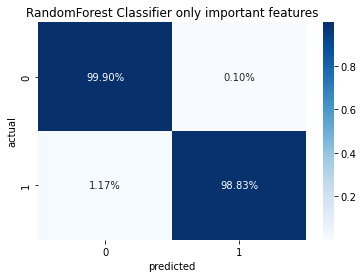

In [653]:
X = asteroids2_rf.drop(['pha'], axis=1)
y = asteroids2_rf['pha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rnd_seed)

rf_imp = RandomForestClassifier(n_estimators=150, random_state=rnd_seed, n_jobs=os.cpu_count())
rf_imp.fit(X_train, y_train)
rf_imp_pred = rf_imp.predict(X_test)
rf_imp_results = metricCalculation(y_test, rf_imp_pred, 'RandomForest Classifier only important features')

Wybór najistotniejszych atrybutów faktycznie poprawił tutaj wyniki predykcji. Spróbujmy oversamplingu

### Po oversamplingu

In [654]:
X = asteroids1.drop(['pha', 'full_name'], axis=1)
y = asteroids1['pha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rnd_seed)

#### Oversampling przy pomoce SMOTE
Do oversamplingu skorzystamy z biblioteki SMOTE (Synthetic Minority Oversampling Technique), który wyrówna dysproporcję klas. Tworzy on nowe obserwacje na podstawie już istniejących dla klasy z mniejszą liczebnością. Stosuje on algorytm k najbliższych sąsiadów, by utworzyć obserwacje, które mogłyby się wpasować w klasę z mniejszą liczebnością

Porównajmy dystrybucję klas *pha* przed i po oversamplingu

In [655]:
fig = make_subplots(rows=1, cols=2)

print("Before Oversampling, counts of label 'N': {}".format(sum(y_train == 'N')))
print("Before Oversampling, counts of label 'Y': {} \n".format(sum(y_train == 'Y')))

pha_dist = pd.Series(y_train).value_counts(normalize=True)*100
pha_dist = pha_dist.round(2)

fig.add_trace(
    go.Bar(x=pha_dist.index, y=pha_dist,
        text=pha_dist,
        name='before oversampling')
)

sm = SMOTE(random_state=rnd_seed)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

print("After Oversampling, counts of label 'N': {}".format(sum(y_train == 'N')))
print("After Oversampling, counts of label 'Y': {}".format(sum(y_train == 'Y')))

pha_dist_os = pd.Series(y_train).value_counts(normalize=True)*100
pha_dist_os = pha_dist_os.round(2)

fig.add_trace(
    go.Bar(y=pha_dist_os, x=pha_dist_os.index,
        text=pha_dist_os,
        name='after oversampling')
)

fig.update_layout(height=300, width=550,
    title_text='PHA distribution before and after Oversampling on training data',
    legend=dict(y=1, x=0.5), margin=dict(l=120, r=20, t=50, b=20))
fig.show()

Before Oversampling, counts of label 'N': 17859
Before Oversampling, counts of label 'Y': 1487 

After Oversampling, counts of label 'N': 17859
After Oversampling, counts of label 'Y': 17859


Liczba obu klas jest równa i wynosi tyle, co klasa *N* przed oversamplingiem. Sprawdźmy jak modele poradzą sobie tym razem

#### Logistic Regression - Oversampling

Accuracy: 94.62
Precision: 80.09
Recall: 95.0
F1: 85.56
TN: 94.54, FP: 5.46, FN: 4.55, TP: 95.45


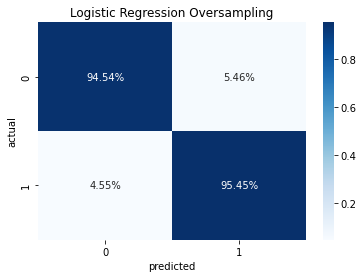

In [656]:
lr_os = LogisticRegression(max_iter=10000, n_jobs=os.cpu_count())
lr_os.fit(X_train, y_train)
lr_os_pred = lr_os.predict(X_test)
lr_os_results = metricCalculation(y_test, lr_os_pred, 'Logistic Regression Oversampling')

Tym razem regresja logistyczna ma wyniki na całkiem obiecującym poziomie, jednak nie może się w tym przypadku równać z lasami losowymi. Sprawdźmy jakie atrybuty tym razem odegrały największą role

#### Logistic Regression - Oversampling; najważniejsze atrybuty

In [657]:
feature_imp_lr_os = pd.DataFrame(lr_os.coef_[0], index=X_train.columns,
    columns=['Importance'])
feature_imp_lr_os = feature_imp_lr_os.abs()
feature_imp_lr_os = feature_imp_lr_os.sort_values(by='Importance', ascending=False)
feature_imp_lr_os.round(6).head(25)

,Importance
H,27.178009
moid_ld,23.197629
moid,23.197629
data_arc,3.566916
first_obs,3.354469
n_obs_used,3.299840
orbit_id_82,3.286790
orbit_id_JPL 5,3.179865
orbit_id_62,3.125868
orbit_id_2,3.024704


In [658]:
important_features_lr_os = feature_imp_lr_os.loc[feature_imp_lr_os['Importance'] > 2].index
important_features_lr_os

Index(['H', 'moid_ld', 'moid', 'data_arc', 'first_obs', 'n_obs_used',
       'orbit_id_82', 'orbit_id_JPL 5', 'orbit_id_62', 'orbit_id_2',
       'orbit_id_JPL 6', 'orbit_id_4', 'orbit_id_JPL 15', 'orbit_id_76',
       'orbit_id_85', 'orbit_id_JPL 7', 'orbit_id_JPL 14', 'rms', 'i',
       'orbit_id_JPL 10', 'condition_code', 'orbit_id_66', 'orbit_id_JPL 9',
       'orbit_id_JPL 12', 'class_AMO', 'orbit_id_129'],
      dtype='object')

In [659]:
important_features_lr_os = list(important_features_lr_os)
if 'pha' not in important_features_lr_os:
    important_features_lr_os.append('pha')
asteroids2_lr_os = asteroids1[important_features_lr_os]
asteroids2_lr_os

,H,moid_ld,moid,data_arc,first_obs,n_obs_used,orbit_id_82,orbit_id_JPL 5,orbit_id_62,orbit_id_2,orbit_id_JPL 6,orbit_id_4,orbit_id_JPL 15,orbit_id_76,orbit_id_85,orbit_id_JPL 7,orbit_id_JPL 14,rms,i,orbit_id_JPL 10,condition_code,orbit_id_66,orbit_id_JPL 9,orbit_id_JPL 12,class_AMO,orbit_id_129,pha
0,0.045531,0.212385,0.212385,1.000000,0.000000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0.086554,0.065374,0,0.000000,0,0,0,1,0,N
1,0.267285,0.284171,0.284171,0.867779,0.139361,0.219264,0,0,0,0,0,0,0,0,0,0,0,0.125861,0.069893,0,0.000000,0,0,0,1,0,N
2,0.194351,0.116401,0.116401,0.811447,0.188609,0.290160,0,0,0,0,0,0,0,0,0,0,0,0.123044,0.056718,0,0.000000,0,0,0,1,0,N
3,0.000000,0.487122,0.487122,0.764861,0.240838,0.826101,0,0,0,0,0,0,0,0,0,0,0,0.110600,0.161147,0,0.000000,0,0,0,1,0,N
4,0.343592,0.151323,0.151323,0.703592,0.298238,0.063664,0,0,0,0,0,0,0,0,0,0,0,0.136493,0.071749,0,0.000000,0,0,0,1,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28871,0.513111,0.031217,0.031217,0.000408,0.999574,0.001534,0,0,0,0,0,0,0,0,0,0,0,0.137582,0.033768,0,0.777778,0,0,0,0,0,Y
28872,0.481956,0.114051,0.114051,0.000021,0.999979,0.001863,0,0,0,0,0,0,0,0,0,0,0,0.087460,0.037173,0,1.000000,0,0,0,1,0,N
28873,0.621290,0.017127,0.017127,0.000000,1.000000,0.004274,0,0,0,0,0,0,0,0,0,0,0,0.150086,0.087894,0,0.777778,0,0,0,0,0,N
28874,0.574747,0.026850,0.026850,0.000000,1.000000,0.003835,0,0,0,0,0,0,0,0,0,0,0,0.103800,0.142606,0,0.777778,0,0,0,0,0,N


In [660]:
X = asteroids2_lr_os.drop(['pha'], axis=1)
y = asteroids2_lr_os['pha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rnd_seed)

sm = SMOTE(random_state=rnd_seed)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

Accuracy: 93.88
Precision: 78.44
Recall: 95.61
F1: 84.32
TN: 93.55, FP: 6.45, FN: 2.34, TP: 97.66


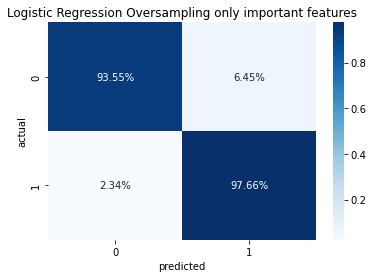

In [661]:
lr_os_imp = LogisticRegression(max_iter=10000, n_jobs=os.cpu_count())
lr_os_imp.fit(X_train, y_train)
lr_os_imp_pred = lr_os_imp.predict(X_test)
lr_os_imp_results = metricCalculation(y_test, lr_os_imp_pred, 'Logistic Regression Oversampling only important features')

Wyniki są dość porównywalne, co ciekawe spadła dokładność predykcji dla klasy *N*

#### RandomForest Classifier - Oversampling

In [662]:
X = asteroids1.drop(['pha', 'full_name'], axis=1)
y = asteroids1['pha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rnd_seed)

sm = SMOTE(random_state=rnd_seed)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

Accuracy: 99.69
Precision: 99.35
Recall: 98.53
F1: 98.93
TN: 99.91, FP: 0.09, FN: 2.86, TP: 97.14


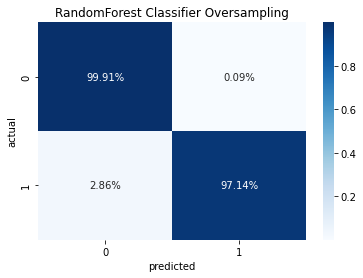

In [663]:
rf_os = RandomForestClassifier(n_estimators=150, random_state=rnd_seed, n_jobs=os.cpu_count())
rf_os.fit(X_train, y_train)
rf_os_pred = rf_os.predict(X_test)
rf_os_results = metricCalculation(y_test, rf_os_pred, 'RandomForest Classifier Oversampling')

Wyniki są pomiędzy lasami losowymi z pełną ilością atrybutów a tymi z tylko najważniejszymi atrybutami. Zostało sprawdzić jak wybranie najważniejszych atrybutów wpłynie na wyniki

#### RandomForest Classifier - Oversampling; najważniejsze atrybuty

In [664]:
feature_imp_rf_os = pd.DataFrame(
    rf_os.feature_importances_, index=X_train.columns,
    columns=['Importance'])
feature_imp_rf_os = feature_imp_rf_os.abs()
feature_imp_rf_os = feature_imp_rf_os.sort_values(by='Importance', ascending=False)
feature_imp_rf_os.round(6).head(20)

,Importance
H,0.190411
moid,0.152633
moid_ld,0.149700
data_arc,0.072143
condition_code,0.063881
n_obs_used,0.038482
sigma_e,0.033357
q,0.032473
class_AMO,0.030097
sigma_n,0.020076


In [665]:
important_features_rf_os = feature_imp_rf_os.loc[feature_imp_rf_os['Importance'] > 0.01].index
important_features_rf_os

Index(['H', 'moid', 'moid_ld', 'data_arc', 'condition_code', 'n_obs_used',
       'sigma_e', 'q', 'class_AMO', 'sigma_n', 'first_obs', 'e', 'sigma_i',
       'class_APO', 'sigma_q', 'i'],
      dtype='object')

In [666]:
important_features_rf_os = list(important_features_rf_os)
if 'pha' not in important_features_rf_os:
    important_features_rf_os.append('pha')
asteroids2_rf_os = asteroids1[important_features_rf_os]
asteroids2_rf_os

,H,moid,moid_ld,data_arc,condition_code,n_obs_used,sigma_e,q,class_AMO,sigma_n,first_obs,e,sigma_i,class_APO,sigma_q,i,pha
0,0.045531,0.212385,0.212385,1.000000,0.000000,1.000000,1.642572e-09,0.864487,1,3.815861e-12,0.000000,0.221386,3.378055e-09,0,3.920112e-09,0.065374,N
1,0.267285,0.284171,0.284171,0.867779,0.000000,0.219264,3.771606e-09,0.914265,1,3.144850e-11,0.139361,0.547846,8.267570e-09,0,1.659313e-08,0.069893,N
2,0.194351,0.116401,0.116401,0.811447,0.000000,0.290160,4.730723e-09,0.806325,1,4.594278e-11,0.188609,0.571604,9.151744e-09,0,1.941236e-08,0.056718,N
3,0.000000,0.487122,0.487122,0.764861,0.000000,0.826101,1.947732e-09,0.955048,1,2.089348e-11,0.240838,0.533872,1.422983e-09,0,8.647772e-09,0.161147,N
4,0.343592,0.151323,0.151323,0.703592,0.000000,0.063664,5.861803e-09,0.823121,1,2.529862e-11,0.298238,0.435986,1.305555e-08,0,1.866234e-08,0.071749,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28871,0.513111,0.031217,0.031217,0.000408,0.777778,0.001534,1.058274e-04,0.586460,0,8.905520e-05,0.999574,0.635966,9.858535e-06,1,7.318470e-06,0.033768,Y
28872,0.481956,0.114051,0.114051,0.000021,1.000000,0.001863,1.110498e-03,0.781664,1,4.881742e-04,0.999979,0.335048,1.878833e-04,0,1.392112e-03,0.037173,N
28873,0.621290,0.017127,0.017127,0.000000,0.777778,0.004274,5.205473e-05,0.500100,0,4.546397e-05,1.000000,0.201042,9.947470e-05,0,1.162151e-04,0.087894,N
28874,0.574747,0.026850,0.026850,0.000000,0.777778,0.003835,4.481815e-05,0.612007,0,8.208194e-05,1.000000,0.128121,2.675881e-04,0,1.598421e-04,0.142606,N


In [667]:
X = asteroids2_rf_os.drop(['pha'], axis=1)
y = asteroids2_rf_os['pha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rnd_seed)

sm = SMOTE(random_state=rnd_seed)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

Accuracy: 99.81
Precision: 99.31
Recall: 99.42
F1: 99.36
TN: 99.89, FP: 0.11, FN: 1.04, TP: 98.96


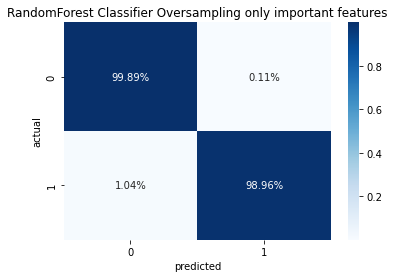

In [668]:
rf_os_imp = RandomForestClassifier(n_estimators=150, random_state=rnd_seed, n_jobs=os.cpu_count())
rf_os_imp.fit(X_train, y_train)
rf_os_imp_pred = rf_os_imp.predict(X_test)
rf_os_imp_results = metricCalculation(y_test, rf_os_imp_pred, 'RandomForest Classifier Oversampling only important features')

Wyniki tutaj są bardzo porównywalne do lasów losowych bez oversamplingu, ale z tylko najważniejszymi atrybutami

## Podsumowanie wyników

In [669]:
results = pd.DataFrame([
    lr_base_results, lr_full_results, lr_imp_results, lr_os_results, lr_os_imp_results,
    rf_results, rf_imp_results, rf_os_results, rf_os_imp_results])
results.set_index('model', inplace=True)
results

,accuracy,precision,recall,f1,tn,fp,fn,tp
model,,,,,,,,
"Logistic Regression (moid, H)",95.30,91.16,74.40,80.23,99.33,0.67,50.52,49.48
Logistic Regression,96.13,89.98,82.20,85.58,98.81,1.19,34.42,65.58
Logistic Regression only important features,96.38,91.97,82.04,86.20,99.14,0.86,35.06,64.94
Logistic Regression Oversampling,94.62,80.09,95.00,85.56,94.54,5.46,4.55,95.45
Logistic Regression Oversampling only important features,93.88,78.44,95.61,84.32,93.55,6.45,2.34,97.66
RandomForest Classifier,99.57,99.46,97.63,98.52,99.94,0.06,4.68,95.32
RandomForest Classifier only important features,99.81,99.36,99.36,99.36,99.90,0.10,1.17,98.83
RandomForest Classifier Oversampling,99.69,99.35,98.53,98.93,99.91,0.09,2.86,97.14
RandomForest Classifier Oversampling only important features,99.81,99.31,99.42,99.36,99.89,0.11,1.04,98.96


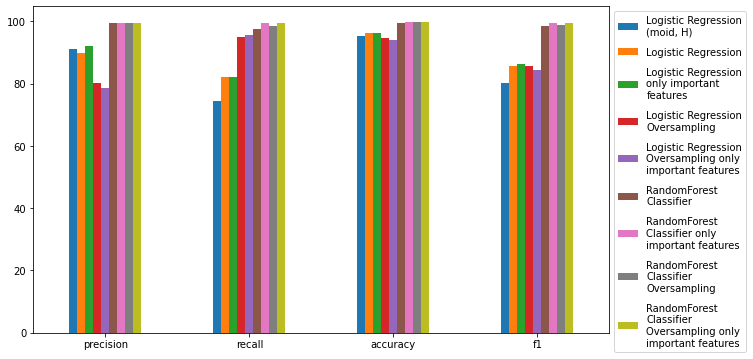

In [670]:
results1 = results[['precision','recall','accuracy','f1']]
fig, ax = plt.subplots()
labels = ['\n'.join(wrap(l, 20)) for l in results1.index]

results1.transpose().plot.bar(ax=ax, rot=0, figsize=(16,6))
ax.legend(labels, bbox_to_anchor=(1,1), labelspacing=1)

plt.subplots_adjust(left=0.2, right=0.7)
plt.show()

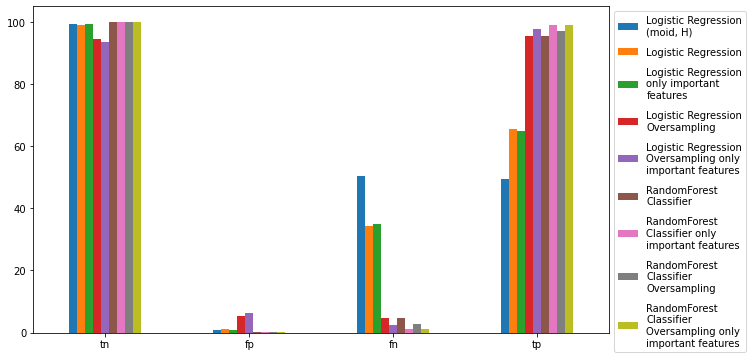

In [671]:
results2 = results[['tn','fp','fn','tp']]
fig, ax = plt.subplots()
labels = ['\n'.join(wrap(l, 20)) for l in results2.index]

results2.transpose().plot.bar(ax=ax, rot=0, figsize=(16,6))
ax.legend(labels, bbox_to_anchor=(1,1), labelspacing=1)

plt.subplots_adjust(left=0.2, right=0.7)
plt.show()

In [672]:
pairs = list()
rows = 2
cols = 4
for i in range(rows):
    for j in range(cols):
        pairs.append((i,j))

fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=results.columns,
    shared_xaxes=True,
    vertical_spacing=0.13)

for pair in pairs:
    idx = cols*pair[0]+pair[1]
    fig.add_trace(
        go.Bar(
            x=results.index,
            y=results[results.columns[idx]],
            orientation='v',
            text=results[results.columns[idx]]),
        row=pair[0]+1, col=pair[1]+1
    )
fig.update_layout(height=900, showlegend=False,
    title_text='Results by models')
fig.show()

Ciężko mówić o dokładności dla modeli regresji logistycznej przed oversamplingiem, ponieważ liczba klasy *Y* zaklasyfikowanych jako *N* (fn) jest bardzo duża (patrz recall). Natomiast w przypadku odwrotnym, dla modeli regresji po oversamplingu, klasyfikacja klasy *N* jako *Y* (fp) jest zdecydowanie wyższa od pozostałych modeli (patrz prescision), są to jednak wartości akceptowalne. Zdecydowanie najlepiej poradziły sobie lasy losowe, co widać po wszystkich miarach - szczególnie widać to po F1-score, czyli średniej harmonicznej pomiędzy precision a recall, najlepszej mierze algorytmów klasyfikujących (przy uwadze na precyzję i czułość). Należy wyróżnić oba modele lasów z wybranymi najistotniejszymi atrybutami.